# Performance assessment with TEMPERATURE in ARPEGE-Climat PPE

<a id="top">This code</a> is assessing model performance based on Surface Air Temperature (tas) within the ARPEGE_Climat Perturbed Physics Ensemble. The metric is then used together with emulators (Multi Linear Regression) to constrain the feedback distribution in the ensemble, but also to study a subset of optimal parameter chosen with the total metric $E_{tot}$ and simulated with ARPEGE-Climat 6.3. <br> 

## It is a 6 steps method : 
### [Step 1 - EOF analysis](#EOF)
### [Step 2 - MultiLinReg predictions](#emulator)
### [Step 3 - Projection of observation dataset](#observation)
### [Step 4 - RMSE estimate](#RMSE)
### [Figure histograms](#histograms)
### [Step 5 - Optimisation](#optim)
### [Step 6 - Optimal subset of parameters](#selection)

# Importe modules

In [1]:
# Computational modules 
%matplotlib inline
import xarray as xr
import glob
import os
import numpy as np
import netCDF4
from netCDF4 import Dataset
import pandas as pd
import re
from array import array
from pylab import *
#import geopandas
from eofs.xarray import Eof
from eofs.multivariate.standard import MultivariateEof

# Plotting modules 
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pandas.plotting
import matplotlib.ticker as ticker
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm

# Scikit-learn
from sklearn import linear_model
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.neural_network import MLPRegressor
from scipy.optimize import minimize
from scipy.optimize import dual_annealing

# Settings

### Variables

In [2]:
variables = ['tas']
variable = 'tas'
TITLE = 'Surface Temperature'
ylabel = '$E_{tas}$ (K)'

### Paths

In [3]:
path_official='/data/scratch/globc/peatier/CMIP6/CNRM-CM6-1/CFMIP/amip/'
path_PPE='/data/scratch/globc/peatier/CNRM-CM6-1_PPE/'

### List of members

In [4]:
nb_p_list = ['p311', 'p312', 'p314', 'p316',
                    'p317', 'p319', 'p320', 'p321', 'p322', 'p324', 'p325', 'p326', 
                    'p329', 'p330', 'p331', 'p332', 'p335', 'p336', 'p337' ,'p338', 
                    'p340', 'p341', 'p343', 'p344', 'p346', 'p347', 'p348', 'p349', 
                    'p350', 'p353', 'p355', 'p357', 'p359', 'p360', 
                    'p361', 'p363', 'p365', 'p367', 'p368', 'p369', 
                    'p372', 'p373', 'p374', 'p375', 'p376', 'p378', 'p381', 'p382', 
                    'p384', 'p386', 'p388', 'p389', 'p391', 'p392', 'p393', 
                    'p394', 'p395', 'p396', 'p398', 'p399', 'p400', 'p404', 
                    'p406', 'p407', 'p409', 'p410', 'p411', 'p412',
                    'p414','p416',
                    'p413','p419','p424','p426','p428','p421','p423',
                    'p425','p427','p429','p430','p436','p438','p431','p433',
                    'p442','p446','p443','p445','p447',
                    'p452','p454','p456','p458','p457','p459',
                    'p460','p465','p467','p469',
                    'p470','p471']

len(nb_p_list)

102

# <a id="EOF">Step 1 - EOF analysis</a> </li>

For each variable, we consider the climatological mean of the model outputs and we calculate empirical orthogonal functions (EOFs) of the control mean states of the ensemble. In contrast to conventional EOFs, the temporal dimension is replaced by the ensemble itself. This analysis provides a compact description of the spatial and temporal variability of the ensemble variance control climate in term of orthogonal functions, or statistical "modes". The resulting EOFs are spatial patterns, while their principal components ($PCs$) are the expansion coefficients showing the amplitude of the EOF in each ensemble member.

### Functions

In [5]:
def get_3D_tas_xarr(path, filename, variables):

    # First step : download the data into dataframe
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    
    # Second step : compute the annual average 
    df = file[variables].mean('time', keep_attrs=True)
    tas = df['tas']
    
    return tas

In [6]:
def eof_map_plot(data, eof_nb, title, label_min, label_max, name_figure):
    # Plot the EOF map 

    lat = data['lat'][:]
    lon = data['lon'][:]

    fig = plt.figure(figsize=(10, 10))
    ax=plt.gca()

    eof = eof_nb-1
    data = data[eof]
    ax.set_title(title, fontsize=18, fontweight = 'bold')

    m = Basemap(projection='robin',
            lat_0=0.5*lat[-1], lon_0=-180.0, resolution='c')
    x, y = m(*np.meshgrid(lon,lat))


    cmap = plt.get_cmap('coolwarm',16)  # define the colormap, take the number of discrete colors you want

    m.pcolormesh(x,y,data,shading='gouraud',cmap=cmap)
    #m.colorbar()
    cbar = m.colorbar(location='bottom', spacing = 'uniform', drawedges=True)
    cbar.set_label(' ', size = 16, style = 'italic')

    m.drawcoastlines()
    m.drawmapboundary()
    plt.clim(label_min, label_max)

    # Enregistrer la figure .....................

    plt.savefig("/data/home/globc/peatier/figures/"+name_figure, 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

    # Show la figure .................
    plt.show()

In [7]:
def pc_plot(data, pc_nb, ymin, ymax, title, name_figure):
    #pc = solver.pcs(pcscaling=1)
    #pc = pc*-1

    # Plot the leading PC time series.
    plt.figure(figsize=(10, 5))
    
    pc = pc_nb - 1
    data[:, pc].plot(color='black', linewidth=2)
    ax = plt.gca()
    ax.axhline(0, color='k', alpha=0.5)
    #ax.axvline(x=(8+1), color='red', alpha=0.5)
    #ax.axvline(x=(11+1), color='red', alpha=0.5)
    #ax.axvline(x=(23+1), color='red', alpha=0.5)
    ax.set_ylim(ymin, ymax)
    ax.set_xlabel('Members', size = 16)
    ax.set_ylabel('Normalized Units', size = 16)
    ax.set_title(title, fontsize=18, 
             fontweight = 'bold')

    # Enregistrer la figure .....................

    plt.savefig("/data/home/globc/peatier/figures/"+name_figure, 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

    # Show la figure .................
    plt.show()

### Get the data

In [8]:
# Official
path = path_official
filename = '*_CNRM-CM6-1_amip_*.nc'
official_amip = get_3D_tas_xarr(path, filename, variables)

# Default simulation
path = path_PPE+'ENSEMBLE1/CNRM-CM6-1_amip_PPE/CNRM-CM6-1_amip_r1i1p1f2/'
filename = '*_CNRM-CM6-1_amip_*.nc'
p1_amip = get_3D_tas_xarr(path, filename, variables)

In [9]:
# PPE amip simulations 
filename='*_amip_*.nc'

N=len(nb_p_list)
amip={}
i = 0
while i<N:
    nb_p = nb_p_list[i]
    print(nb_p)
    path=path_PPE+'ENSEMBLE2/CNRM-CM6-1_amip_LHS500_PPE/CNRM-CM6-1_amip_r1i1'+str(nb_p)+'f2/'
    amip[str(nb_p)] = get_3D_tas_xarr(path, filename, variables)
    i=i+1  

p311
p312
p314
p316
p317
p319
p320
p321
p322
p324
p325
p326
p329
p330
p331
p332
p335
p336
p337
p338
p340
p341
p343
p344
p346
p347
p348
p349
p350
p353
p355
p357
p359
p360
p361
p363
p365
p367
p368
p369
p372
p373
p374
p375
p376
p378
p381
p382
p384
p386
p388
p389
p391
p392
p393
p394
p395
p396
p398
p399
p400
p404
p406
p407
p409
p410
p411
p412
p414
p416
p413
p419
p424
p426
p428
p421
p423
p425
p427
p429
p430
p436
p438
p431
p433
p442
p446
p443
p445
p447
p452
p454
p456
p458
p457
p459
p460
p465
p467
p469
p470
p471


In [10]:
#amip['official'] = official_amip
amip['p1'] = p1_amip

### Create EOF input matrix

In [243]:
n=len(nb_p_list)
amip_list=[0]*(n+1)

#amip_list[0] = amip['official']
amip_list[0] = amip['p1']

i = 0
while i<n:
    nb_p = nb_p_list[i]
    #print(nb_p)
    tmp = amip[str(nb_p)]
    #j=i+1
    amip_list[i+1] = tmp
    i+=1

In [244]:
matrix = xr.combine_nested(amip_list, concat_dim=['time'])
matrix

<xarray.DataArray 'tas' (time: 103, lat: 128, lon: 256)>
dask.array<concatenate, shape=(103, 128, 256), dtype=float32, chunksize=(1, 128, 256), chunktype=numpy.ndarray>
Coordinates:
    height   float64 2.0
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
Dimensions without coordinates: time
Attributes:
    online_operation:    average
    cell_methods:        area: time: mean
    interval_operation:  900 s
    interval_write:      1 month
    standard_name:       air_temperature
    description:         Near-Surface Air Temperature
    long_name:           Near-Surface Air Temperature
    history:             none
    units:               K
    cell_measures:       area: areacella

### EOF analysis

In [245]:
# Mean wheigted with cos(lat) : 
lats = matrix['lat'][:]
coslat = np.cos(np.deg2rad(lats)).clip(0., 1.)
wgts = np.sqrt(coslat).drop(labels='height').values
W =wgts[np.newaxis,:,np.newaxis]
#W

In [407]:
# Compute anomalies by removing the time-mean.
mean = matrix.mean(axis=0)
anom = matrix - mean
anom

<xarray.DataArray 'tas' (time: 103, lat: 128, lon: 256)>
dask.array<sub, shape=(103, 128, 256), dtype=float32, chunksize=(1, 128, 256), chunktype=numpy.ndarray>
Coordinates:
    height   float64 2.0
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
Dimensions without coordinates: time

In [408]:
mean_df = mean.to_dataframe(name=str(variable)+'mean').drop(labels = 'height', axis=1)
mean_df

anom_df =  anom.to_dataframe(name=str(variables[0])+'mean').drop(labels = 'height', axis=1)
anom_df

['climatology', 'temperature']mean
time lat        lon                                          
0    -88.927735 0.00000                             -1.214523
                1.40625                             -1.214523
                2.81250                             -1.214523
                4.21875                             -1.214523
                5.62500                             -1.214523
...                                                       ...
102   88.927735 352.96875                           -2.674088
                354.37500                           -2.674088
                355.78125                           -2.674088
                357.18750                           -2.674088
                358.59375                           -2.674088

[3375104 rows x 1 columns]

In [413]:
# Create an EOF solver to do the EOF analysis. 
solver = Eof(anom, weights=W)

eof = solver.eofsAsCovariance(neofs=10, pcscaling=1)
pc = solver.pcs(pcscaling=1)

In [414]:
varFrac = solver.varianceFraction(neigs=10)
varFrac

<xarray.DataArray 'variance_fractions' (mode: 10)>
array([0.59029305, 0.1431606 , 0.05863993, 0.03041701, 0.02783081,
       0.02001883, 0.01525671, 0.00989492, 0.00796787, 0.00709969],
      dtype=float32)
Coordinates:
  * mode     (mode) int64 0 1 2 3 4 5 6 7 8 9
Attributes:
    long_name:  variance_fractions

In [415]:
eof[0]

<xarray.DataArray 'eofs' (lat: 128, lon: 256)>
array([[-2.16255  , -2.16255  , -2.16255  , ..., -2.16255  , -2.16255  ,
        -2.16255  ],
       [-2.0620189, -2.0620189, -2.0620189, ..., -2.0620189, -2.0620189,
        -2.0620189],
       [-2.212378 , -2.212378 , -2.212378 , ..., -2.1766496, -2.212378 ,
        -2.212378 ],
       ...,
       [-1.5700235, -1.5700235, -1.5700235, ..., -1.5750202, -1.5700235,
        -1.5700235],
       [-1.6971078, -1.6971078, -1.6971078, ..., -1.6971078, -1.6971078,
        -1.6971078],
       [-1.8233392, -1.8233392, -1.8233392, ..., -1.8233392, -1.8233392,
        -1.8233392]], dtype=float32)
Coordinates:
    mode     int64 0
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
Attributes:
    long_name:  covariance_between_pcs_and_tas

In [252]:
eof[0]

<xarray.DataArray 'eofs' (lat: 128, lon: 256)>
array([[-2.16255  , -2.16255  , -2.16255  , ..., -2.16255  , -2.16255  ,
        -2.16255  ],
       [-2.0620189, -2.0620189, -2.0620189, ..., -2.0620189, -2.0620189,
        -2.0620189],
       [-2.212378 , -2.212378 , -2.212378 , ..., -2.1766496, -2.212378 ,
        -2.212378 ],
       ...,
       [-1.5700235, -1.5700235, -1.5700235, ..., -1.5750202, -1.5700235,
        -1.5700235],
       [-1.6971078, -1.6971078, -1.6971078, ..., -1.6971078, -1.6971078,
        -1.6971078],
       [-1.8233392, -1.8233392, -1.8233392, ..., -1.8233392, -1.8233392,
        -1.8233392]], dtype=float32)
Coordinates:
    mode     int64 0
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
Attributes:
    long_name:  covariance_between_pcs_and_tas

In [412]:
pc[0]

<xarray.DataArray 'pcs' (mode: 103)>
array([ 3.81411886e+00,  4.34926605e+01,  2.86217270e+01,  8.32248020e+00,
        2.02165604e+00, -1.16892395e+01,  5.46606588e+00,  9.74049854e+00,
       -2.13439918e+00,  1.82623518e+00,  2.75906181e+00,  8.39439964e+00,
       -7.08807039e+00, -5.96718073e+00, -6.33252025e-01,  9.52956676e+00,
        1.24164114e+01,  7.75678349e+00,  5.22458792e-01, -3.90489388e+00,
       -6.72507572e+00,  1.79548514e+00, -5.19429207e+00, -8.75903511e+00,
       -1.09694195e+01,  6.65181637e-01, -2.37232232e+00,  1.67258275e+00,
        1.06008730e+01,  3.60756445e+00,  4.37891424e-01,  4.88774586e+00,
        1.04303432e+00, -1.62811744e+00, -2.69807768e+00, -2.80389547e+00,
        4.43947220e+00,  1.14502311e+00,  3.26810026e+00, -7.70657003e-01,
        3.11015606e+00,  6.32945776e+00,  5.26930189e+00,  5.22882891e+00,
        6.55200052e+00, -3.21954584e+00, -4.46469927e+00,  5.38475871e-01,
        8.67341101e-01,  1.51854825e+00, -1.34058321e+00, -6.35445476e-01,
        2.99252892e+00, -2.82890797e+00, -2.38304043e+00, -2.78221917e+00,
        3.10670638e+00,  3.00417042e+00,  7.81290293e-01, -3.44517857e-01,
       -1.33941901e+00, -5.08637130e-01,  5.43107390e-01, -9.11257088e-01,
        2.50436687e+00, -4.02779162e-01,  4.33471203e+00, -7.33158708e-01,
        1.33247864e+00, -1.39061689e+00, -1.74082249e-01, -4.37766647e+00,
       -2.06239963e+00, -3.72030735e-01, -7.55092001e+00,  1.25314081e+00,
       -1.32769454e+00, -4.44168329e-01,  2.42590404e+00, -1.34276080e+00,
       -2.54806548e-01,  2.45428586e+00,  1.51778090e+00,  1.31413952e-01,
       -1.47765744e+00,  4.69109714e-01, -2.62135696e+00,  8.70274425e-01,
        2.47918725e+00,  2.39426589e+00,  1.33646119e+00,  1.06470394e+00,
       -1.24149859e+00,  1.02682650e+00,  1.58338025e-01,  3.00528431e+00,
       -1.06037951e+00, -5.95539868e-01,  3.28926176e-01,  8.34502459e-01,
       -1.67974621e-01,  1.50473490e-01, -1.29223417e-06], dtype=float32)
Coordinates:
    time     int64 0
  * mode     (mode) int64 0 1 2 3 4 5 6 7 8 9 ... 94 95 96 97 98 99 100 101 102

In [423]:
pc[0]*sqrt(eigenvalues)

<xarray.DataArray (mode: 103)>
array([ 3.81411886e+00,  4.34926605e+01,  2.86217270e+01,  8.32248020e+00,
        2.02165604e+00, -1.16892405e+01,  5.46606588e+00,  9.74049854e+00,
       -2.13439918e+00,  1.82623518e+00,  2.75906157e+00,  8.39439964e+00,
       -7.08807039e+00, -5.96718073e+00, -6.33252025e-01,  9.52956676e+00,
        1.24164114e+01,  7.75678349e+00,  5.22458792e-01, -3.90489388e+00,
       -6.72507572e+00,  1.79548514e+00, -5.19429207e+00, -8.75903511e+00,
       -1.09694195e+01,  6.65181637e-01, -2.37232232e+00,  1.67258275e+00,
        1.06008730e+01,  3.60756445e+00,  4.37891424e-01,  4.88774633e+00,
        1.04303432e+00, -1.62811744e+00, -2.69807768e+00, -2.80389547e+00,
        4.43947220e+00,  1.14502311e+00,  3.26810026e+00, -7.70657003e-01,
        3.11015606e+00,  6.32945776e+00,  5.26930189e+00,  5.22882891e+00,
        6.55200052e+00, -3.21954560e+00, -4.46469927e+00,  5.38475871e-01,
        8.67341101e-01,  1.51854825e+00, -1.34058321e+00, -6.35445476e-01,
        2.99252892e+00, -2.82890821e+00, -2.38304043e+00, -2.78221917e+00,
        3.10670662e+00,  3.00417042e+00,  7.81290352e-01, -3.44517887e-01,
       -1.33941901e+00, -5.08637130e-01,  5.43107390e-01, -9.11257088e-01,
        2.50436687e+00, -4.02779162e-01,  4.33471203e+00, -7.33158708e-01,
        1.33247864e+00, -1.39061689e+00, -1.74082249e-01, -4.37766647e+00,
       -2.06239963e+00, -3.72030735e-01, -7.55092001e+00,  1.25314081e+00,
       -1.32769454e+00, -4.44168329e-01,  2.42590404e+00, -1.34276080e+00,
       -2.54806548e-01,  2.45428586e+00,  1.51778090e+00,  1.31413952e-01,
       -1.47765744e+00,  4.69109714e-01, -2.62135696e+00,  8.70274484e-01,
        2.47918725e+00,  2.39426589e+00,  1.33646119e+00,  1.06470394e+00,
       -1.24149859e+00,  1.02682650e+00,  1.58338025e-01,  3.00528431e+00,
       -1.06037951e+00, -5.95539868e-01,  3.28926176e-01,  8.34502518e-01,
       -1.67974621e-01,  1.50473490e-01, -1.29223417e-06], dtype=float32)
Coordinates:
    time     int64 0
  * mode     (mode) int64 0 1 2 3 4 5 6 7 8 9 ... 94 95 96 97 98 99 100 101 102

In [417]:
eigenvalues = solver.eigenvalues()
eigenvalues

<xarray.DataArray 'eigenvalues' (mode: 103)>
array([9.03084473e+03, 2.19020215e+03, 8.97127502e+02, 4.65347382e+02,
       4.25781281e+02, 3.06266479e+02, 2.33411179e+02, 1.51381638e+02,
       1.21899796e+02, 1.08617577e+02, 9.78974838e+01, 8.56732025e+01,
       6.93729019e+01, 6.47471542e+01, 6.12442474e+01, 5.84196472e+01,
       5.21047974e+01, 4.19449387e+01, 4.00680923e+01, 3.89677467e+01,
       3.61395760e+01, 3.43372269e+01, 3.30178528e+01, 3.02078915e+01,
       2.73511276e+01, 2.64291706e+01, 2.48166561e+01, 2.18501625e+01,
       2.12354755e+01, 2.03716869e+01, 1.90753002e+01, 1.84962826e+01,
       1.63870049e+01, 1.54755812e+01, 1.51158314e+01, 1.48607988e+01,
       1.46327667e+01, 1.32178164e+01, 1.28320408e+01, 1.23479319e+01,
       1.18630877e+01, 1.17443323e+01, 1.14036331e+01, 1.09959145e+01,
       1.08719454e+01, 9.75569153e+00, 9.65994930e+00, 9.08228397e+00,
       8.88221455e+00, 8.57429028e+00, 8.46261597e+00, 8.08699322e+00,
       7.82945204e+00, 7.41901398e+00, 7.32582855e+00, 7.13498211e+00,
       6.91987419e+00, 6.83444452e+00, 6.39542770e+00, 6.07936907e+00,
       6.05648804e+00, 5.88351583e+00, 5.75140905e+00, 5.41330862e+00,
       5.29516411e+00, 5.15887642e+00, 4.90399790e+00, 4.74701214e+00,
       4.67428446e+00, 4.63420963e+00, 4.46342325e+00, 4.40715504e+00,
       4.35070992e+00, 4.23059082e+00, 4.15615082e+00, 4.04758692e+00,
       4.00273561e+00, 3.94830060e+00, 3.77871966e+00, 3.72173524e+00,
       3.66358089e+00, 3.52049971e+00, 3.37441802e+00, 3.33283401e+00,
       3.26558065e+00, 3.12226033e+00, 3.10350633e+00, 2.90077329e+00,
       2.87768102e+00, 2.82387042e+00, 2.78437948e+00, 2.72528577e+00,
       2.62195992e+00, 2.56526542e+00, 2.41477537e+00, 2.37275863e+00,
       2.33401275e+00, 2.27492952e+00, 2.16543460e+00, 2.14917088e+00,
       2.12511230e+00, 1.93447769e+00, 1.68623969e-12], dtype=float32)
Coordinates:
  * mode     (mode) int64 0 1 2 3 4 5 6 7 8 9 ... 94 95 96 97 98 99 100 101 102
Attributes:
    long_name:  eigenvalues

# EOF 1 : plotting 

In [73]:
varFrac_list = []
for i in varFrac.values :
    tmp = round(i, 2)
    varFrac_list.append(tmp)
varFrac_list

[0.59, 0.14, 0.06, 0.03, 0.03, 0.02, 0.02, 0.01, 0.01, 0.01]

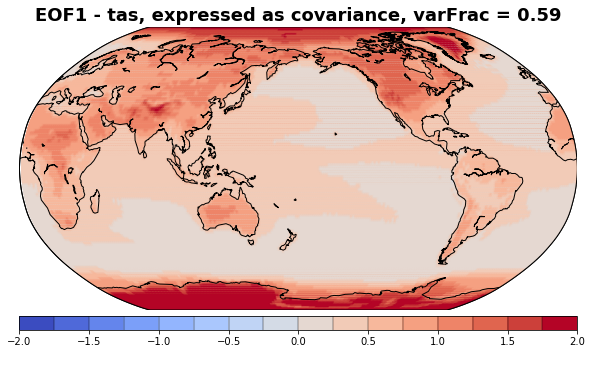

In [74]:
data = eof*(-1)
eof_nb = 1
title = "EOF1 - "+str(variables[0])+", expressed as covariance, varFrac = "+str(varFrac_list[0])
label_min = -2
label_max = 2
name_figure = "PPE2_EOF1map_"+str(variable)+".png"
eof_map_plot(data, eof_nb, title, label_min, label_max, name_figure)

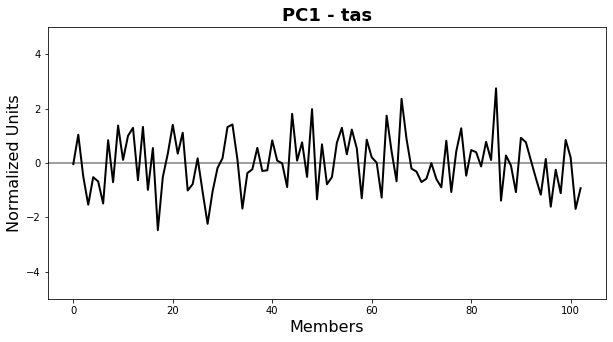

In [34]:
data = pc*(-1)
pc_nb = 1
ymin = -5
ymax = 5
title = "PC1 - "+str(variables[0])
name_figure = "PPE2_EOF1pc_"+str(variables[0])+".png"
pc_plot(data, pc_nb, ymin, ymax, title, name_figure)

### EOF 2 : plotting 

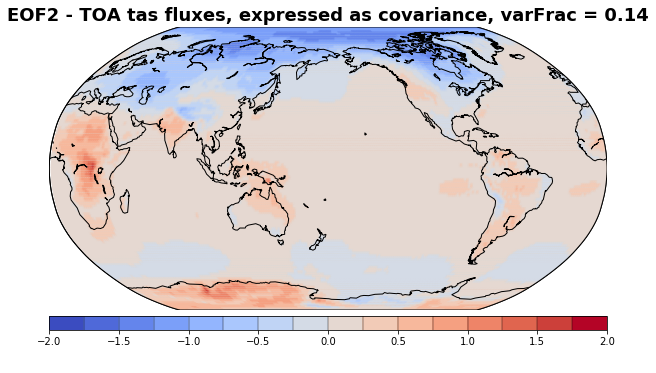

In [75]:
data = eof*(-1)
eof_nb = 2
title = "EOF2 - "+str(variables[0])+", expressed as covariance, varFrac = "+str(varFrac_list[1])
label_min = -2
label_max = 2
name_figure = 'PPE2_EOF2map_'+str(variable)+'.png'
eof_map_plot(data, eof_nb, title, label_min, label_max, name_figure)

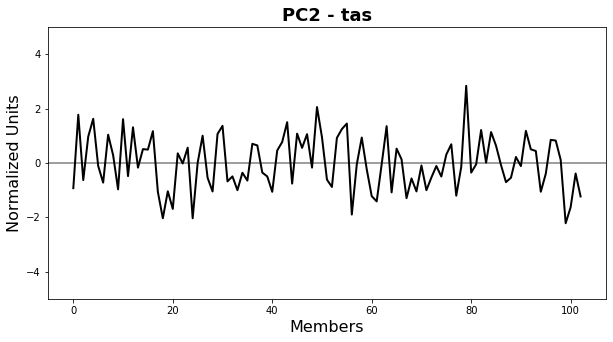

In [38]:
data = pc*(-1)
pc_nb = 2
ymin = -5
ymax = 5
title = 'PC2 - '+str(variable)
name_figure = 'PPE2_EOF2pc_'+str(variable)+'.png'
pc_plot(data, pc_nb, ymin, ymax, title, name_figure)

### EOF 3 : plotting

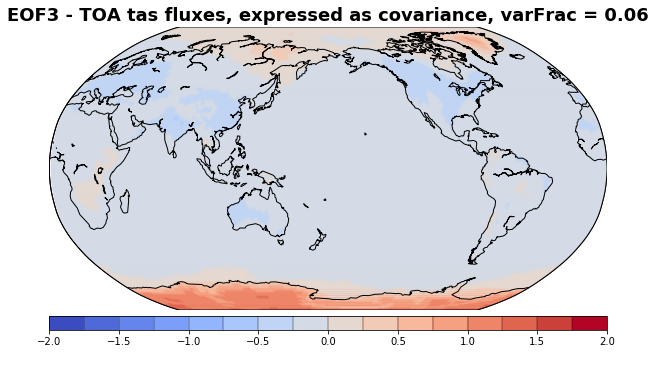

In [76]:
data = eof*(-1)
eof_nb = 3
title = 'EOF3 - TOA '+str(variable)+' fluxes, expressed as covariance, varFrac = '+str(varFrac_list[2])
label_min = -2
label_max = 2
name_figure = 'PPE2_EOF3map_'+str(variable)+'.png'
eof_map_plot(data, eof_nb, title, label_min, label_max, name_figure)

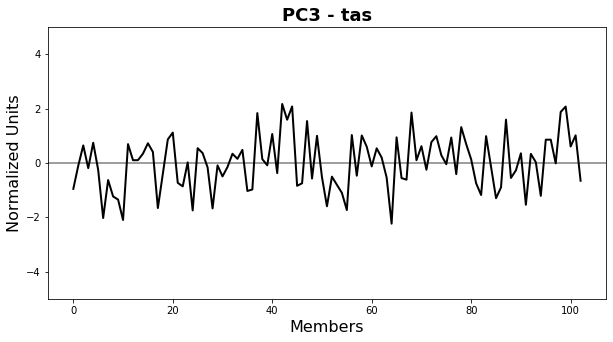

In [42]:
data = pc*(-1)
pc_nb = 3
ymin = -5
ymax = 5
title = 'PC3 - '+str(variable)
name_figure = 'PPE2_EOF3pc_'+str(variable)+'.png'
pc_plot(data, pc_nb, ymin, ymax, title, name_figure)

### EOF 4 : plotting 

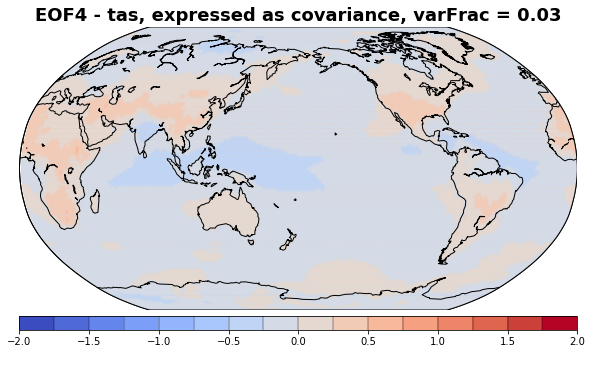

In [77]:
data = eof
eof_nb = 4
title = 'EOF4 - '+str(variable)+', expressed as covariance, varFrac = '+str(varFrac_list[3])
label_min = -2
label_max = 2
name_figure = 'PPE2_EOF4map_'+str(variable)+'.png'
eof_map_plot(data, eof_nb, title, label_min, label_max, name_figure)

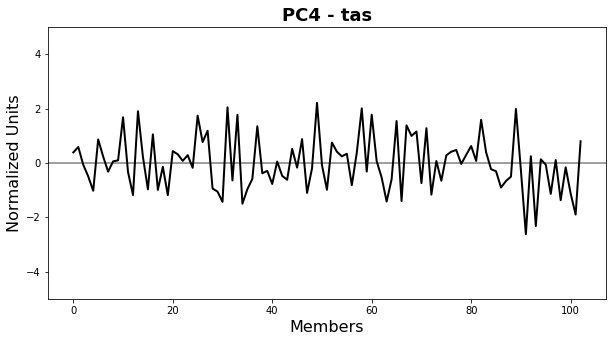

In [45]:
data = pc
pc_nb = 4
ymin = -5
ymax = 5
title = 'PC4 - '+str(variable)
name_figure = 'PPE2_EOF4pc_'+str(variable)+'.png'
pc_plot(data, pc_nb, ymin, ymax, title, name_figure)

### EOF 5 : plotting 

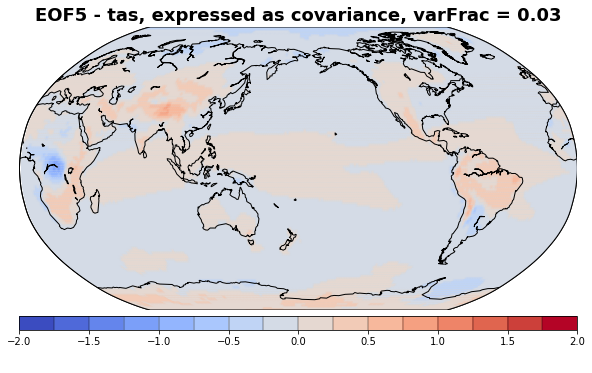

In [78]:
data = eof
eof_nb = 5
title = 'EOF5 - '+str(variable)+', expressed as covariance, varFrac = '+str(varFrac_list[4])
label_min = -2
label_max = 2
name_figure = 'PPE2_EOF5map_'+str(variable)+'.png'
eof_map_plot(data, eof_nb, title, label_min, label_max, name_figure)

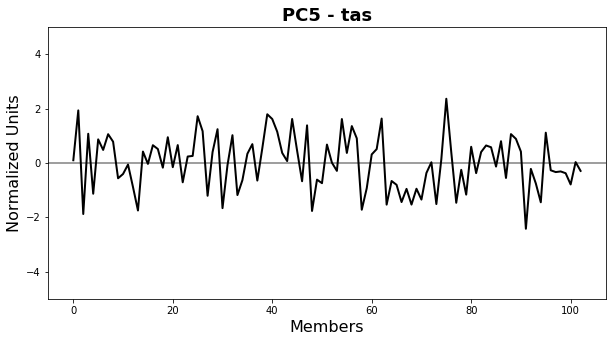

In [49]:
data = pc
pc_nb = 5
ymin = -5
ymax = 5
title = 'PC5 - '+str(variable)
name_figure = 'PPE2_EOF5pc_'+str(variable)+'.png'
pc_plot(data, pc_nb, ymin, ymax, title, name_figure)

### Save data

#### EOFs

In [118]:
EOF1_df = eof[0].to_dataframe().drop(labels = 'mode', axis=1)

# Save the numpy array in a file  
EOF1_df.to_pickle("/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOFmap1_"+str(variable)+".npy")

In [119]:
EOF2_df = eof[1].to_dataframe().drop(labels = 'mode', axis=1)

# Save the numpy array in a file  
EOF2_df.to_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOFmap2_'+str(variable)+'.npy')

In [120]:
EOF3_df = eof[2].to_dataframe().drop(labels = 'mode', axis=1)

# Save the numpy array in a file  
EOF3_df.to_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOFmap3_'+str(variable)+'.npy')

In [121]:
EOF4_df = eof[3].to_dataframe().drop(labels = 'mode', axis=1)

# Save the numpy array in a file  
EOF4_df.to_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOFmap4_'+str(variable)+'.npy')

In [122]:
EOF5_df = eof[4].to_dataframe().drop(labels = 'mode', axis=1)

# Save the numpy array in a file  
EOF5_df.to_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOFmap5_'+str(variable)+'.npy')

#### Principal Components

In [111]:
#pc1_official = pc[0, 0]
pc1_p1 = pc[0, 0]

pc1 = pc[1:, 0]

# Save the numpy array in a file   
#np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/official_EOF1pc_'+str(variable)+'.npy', pc1_official)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/p1_EOF1pc_'+str(variable)+'.npy', pc1_p1)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF1pc_'+str(variable)+'.npy', pc1)

In [112]:
#pc2_official = pc[0,1]
pc2_p1 = pc[0,1]
pc2 = pc[1:, 1]

# Save the numpy array in a file   
#np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/official_EOF2pc_'+str(variable)+'.npy', pc2_official)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/p1_EOF2pc_'+str(variable)+'.npy', pc2_p1)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF2pc_'+str(variable)+'.npy', pc2)

In [113]:
#pc3_official = pc[0,2]
pc3_p1 = pc[0,2]
pc3 = pc[1:, 2]

# Save the numpy array in a file   
#np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/official_EOF3pc_'+str(variable)+'.npy', pc3_official)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/p1_EOF3pc_'+str(variable)+'.npy', pc3_p1)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF3pc_'+str(variable)+'.npy', pc3)

In [114]:
#pc4_official = pc[0, 3]
pc4_p1 = pc[0, 3]
pc4 = pc[1:, 3]

# Save the numpy array in a file   
#np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/official_EOF4pc_'+str(variable)+'.npy', pc4_official)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/p1_EOF4pc_'+str(variable)+'.npy', pc4_p1)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF4pc_'+str(variable)+'.npy', pc4)

In [115]:
#pc5_official = pc[0, 4]
pc5_p1 = pc[0, 4]
pc5 = pc[1:, 4]

# Save the numpy array in a file   
#np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/official_EOF5pc_'+str(variable)+'.npy', pc5_official)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/p1_EOF5pc_'+str(variable)+'.npy', pc5_p1)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF5pc_'+str(variable)+'.npy', pc5)

#### Variance explained, Mean and Anomalies

In [116]:
## varFrac

# Save the numpy array in a file   
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_varFrac_'+str(variable)+'.npy', varFrac)

In [117]:
# Save the Mean and Anom numpy arrays in a file  

mean_df.to_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_'+str(variable)+'_mean.npy')
anom_df.to_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_'+str(variable)+'_anom.npy')

### [Back to the top](#top)

# <a id="emulator">Step 2 - MultiLinReg predictions</a> </li>

Use of statistical emulators to predict, based on the perturbed parameter values, ARPEGE-Climat's outputs. The emulators must predict both the climate control mean state (here the global mean tas) and the global net feedback (in another code).  


The emulator is a simple multi linear regression model built and trained to predict the five first $PCs$ of the EOF analysis estimated in [Step 1](#EOF). It is expressed as followed : 
\begin{equation}
    Y = \Sigma_{j=1}^K a_jx_j + R 
    \label{eq_emulator}
\end{equation}

with $Y = PC_i$ the PC of one mode of the EOF analysis ($i=5$), $x_j$ the parameter values, $a_j$ the regression coefficients estimated based on the training of the model, $R$ the intercept and $K=30$ the number of perturbed parameter.

### Functions

In [79]:
import sys
sys.path.append('/data/home/globc/peatier/CNRMppe')
import Fonctions_emulation
from Fonctions_emulation import Lasso_tunage
from Fonctions_emulation import Lasso_model
from Fonctions_emulation import plot_model_skill
from Fonctions_emulation import plot_model_skill_lines
from Fonctions_emulation import Lasso_pred
from Fonctions_emulation import MultiLinReg_model
from Fonctions_emulation import MultiLinReg_pred

### EOF 1 - prediction

In [86]:
# Set the X and Y : Y = f(X)
X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
y = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF1pc_"+variable+".npy")
param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")

In [87]:
DFYeq = MultiLinReg_model(X,y,param_names, nb_p_list)
DFYeq

Intercept: 
 -0.00039349039833922947
Coefficients: 
 [-0.30411591 -0.36973268 -0.3675782  -0.08500517  0.00212989 -0.23283144
 -0.02651141  0.10938961  0.1149316   0.29124554 -0.12185862 -0.31880178
  0.26582322  0.27300696 -0.10213039 -0.05952738  0.04575873 -0.08694135
 -0.12457941  0.02474785 -0.02083094 -0.0476018   0.07228328  0.03636241
 -0.06231205 -0.25417726 -0.04322043  0.11048385  0.0503155  -0.05750126]
Score: 
 0.8983644469417661


,y_true,y_eq,members,members_0
0,-1.037732,-1.239767,p311,0
1,0.500078,0.656048,p312,1
2,1.538930,1.775405,p314,2
3,0.524819,0.405773,p316,3
4,0.683105,1.099905,p317,4
...,...,...,...,...
97,1.117563,0.990206,p465,97
98,-0.847133,-0.209637,p467,98
99,-0.200386,-0.294009,p469,99
100,1.692824,1.890534,p470,100


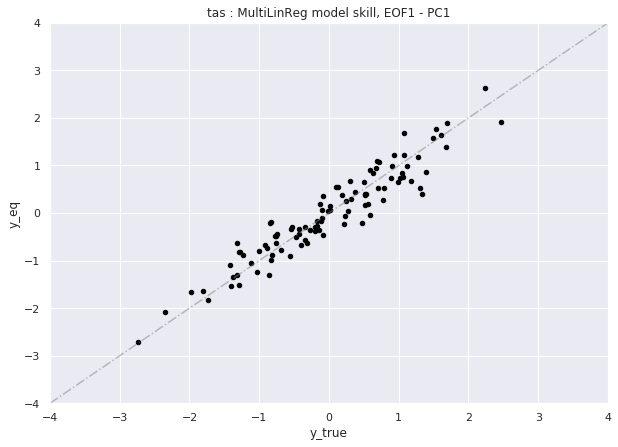

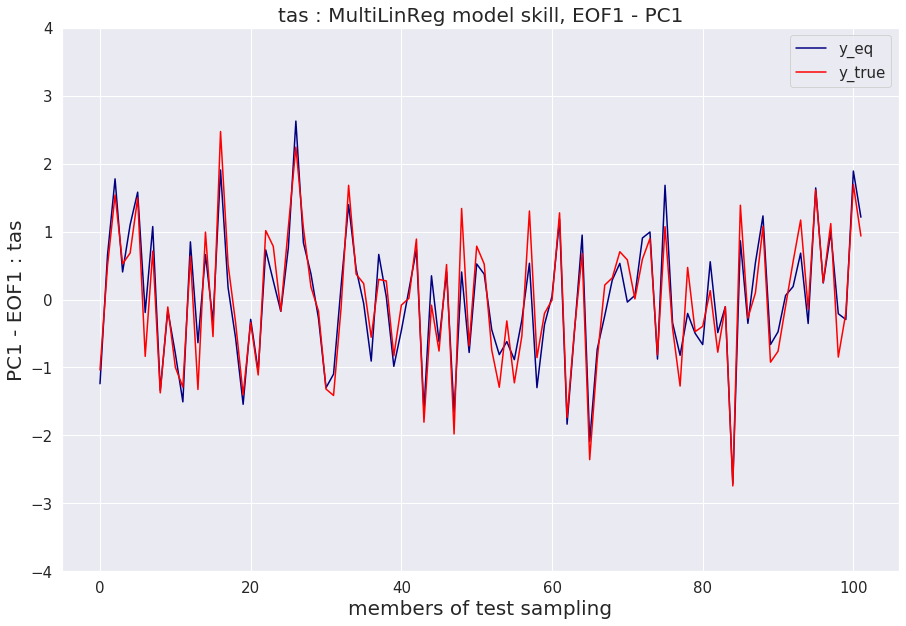

In [88]:
df = DFYeq
title = variable+' : MultiLinReg model skill, EOF1 - PC1'
xmin = -4
xmax = 4
ymin = -4
ymax = 4
name = 'MultiLinReg_'+variable+'_skill_pc1.png'

plot_model_skill(df, title, xmin, xmax, ymin, ymax, name)

xlabel = 'members of test sampling'
ylabel = 'PC1 - EOF1 : '+variable

plot_model_skill_lines(df, title, xlabel, ylabel, ymin, ymax)

In [89]:
LHS = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_param_standard.npy")

DFYpred = MultiLinReg_pred(LHS,X,y, param_names)
DFYpred

,y_pred,members
0,0.053160,102.0
1,-0.259237,103.0
2,-0.050450,104.0
3,1.133615,105.0
4,-0.657845,106.0
...,...,...
99995,-0.349083,100097.0
99996,0.925939,100098.0
99997,-1.077140,100099.0
99998,1.019538,100100.0


#### Save data

In [90]:
MultiLinReg_validation = DFYeq['y_eq'].values
MultiLinReg_prediction = DFYpred['y_pred'].values

# Save the predictionc in numpy arrays : 
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_validation_eof1_'+variable+'.npy', 
        MultiLinReg_validation)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_prediction_eof1_'+variable+'.npy', 
        MultiLinReg_prediction)

### EOF 2 - prediction

In [91]:
# Set the X and Y : Y = f(X)
X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
y = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF2pc_"+variable+".npy")
param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")

In [92]:
DFYeq = MultiLinReg_model(X,y,param_names, nb_p_list)
DFYeq

Intercept: 
 -0.009111175966430518
Coefficients: 
 [-0.57903314 -0.33637271 -0.43321168 -0.02599539  0.01884751 -0.1471156
  0.01184136  0.02332496 -0.20143964 -0.07736726  0.12287283  0.16838948
 -0.24545819 -0.2392465   0.03988484  0.04099866 -0.04028856 -0.08006257
 -0.01531262 -0.03568934 -0.00971542  0.10612508 -0.04935732 -0.19563826
 -0.02511651  0.1357766   0.05382811 -0.04128717 -0.26068638 -0.13548014]
Score: 
 0.8968249630163427


,y_true,y_eq,members,members_0
0,-1.772081,-0.910830,p311,0
1,0.633004,0.181233,p312,1
2,-0.967792,-1.021747,p314,2
3,-1.622346,-1.195464,p316,3
4,0.110459,-0.348282,p317,4
...,...,...,...,...
97,-0.113455,-0.528991,p465,97
98,2.220053,1.708696,p467,98
99,1.630405,1.556590,p469,99
100,0.389283,0.851052,p470,100


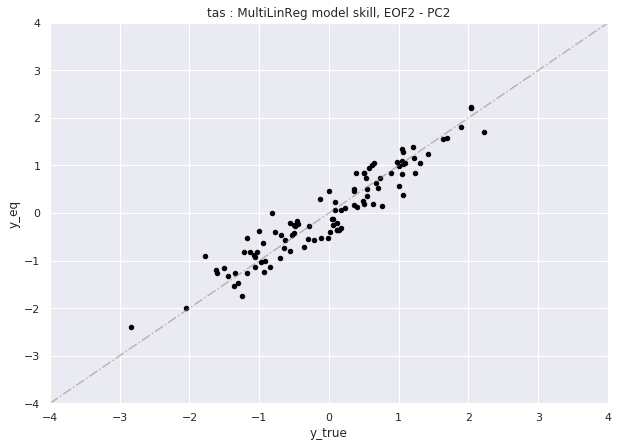

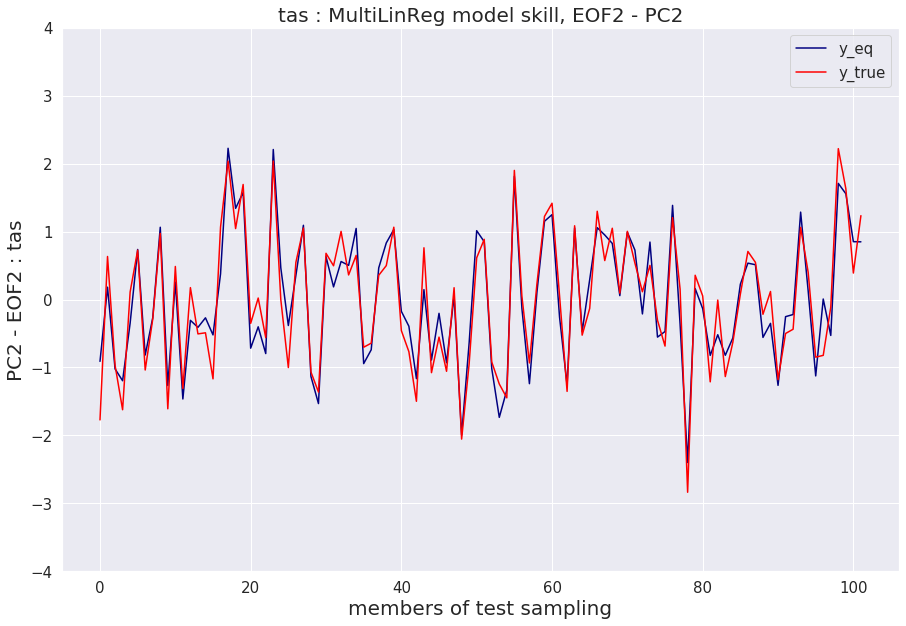

In [93]:
df = DFYeq
title = variable+' : MultiLinReg model skill, EOF2 - PC2'
xmin = -4
xmax = 4
ymin = -4
ymax = 4
name = 'MultiLinReg_'+variable+'_skill_pc2.png'

plot_model_skill(df, title, xmin, xmax, ymin, ymax, name)

xlabel = 'members of test sampling'
ylabel = 'PC2 - EOF2 : '+variable

plot_model_skill_lines(df, title, xlabel, ylabel, ymin, ymax)

In [94]:
LHS = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_param_standard.npy")

DFYpred = MultiLinReg_pred(LHS,X,y, param_names)
DFYpred

,y_pred,members
0,0.591416,102.0
1,0.647073,103.0
2,0.146491,104.0
3,-1.250214,105.0
4,-0.100945,106.0
...,...,...
99995,0.723257,100097.0
99996,0.211934,100098.0
99997,0.734859,100099.0
99998,1.927900,100100.0


#### Save data

In [95]:
MultiLinReg_validation = DFYeq['y_eq'].values
MultiLinReg_prediction = DFYpred['y_pred'].values

# Save the predictionc in numpy arrays : 
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_validation_eof2_'+variable+'.npy', 
        MultiLinReg_validation)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_prediction_eof2_'+variable+'.npy', 
        MultiLinReg_prediction)

### EOF 3 - prediction

In [96]:
# Set the X and Y : Y = f(X)
X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
y = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF3pc_"+variable+".npy")
param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")

In [97]:
DFYeq = MultiLinReg_model(X,y,param_names, nb_p_list)
DFYeq

Intercept: 
 -0.009368467692504651
Coefficients: 
 [-0.25938849 -0.03362107  0.07412866 -0.30310744  0.01564701  0.39770513
 -0.0377941  -0.10250187 -0.05162376 -0.03387704 -0.29073604 -0.40178162
 -0.30221968  0.11484699  0.32420051 -0.0731238   0.06759004 -0.05535341
 -0.03156071  0.1557839  -0.06213536 -0.04268082 -0.27173001 -0.09238719
 -0.02559025 -0.22042252 -0.00423384  0.01688671 -0.21542395 -0.1241422 ]
Score: 
 0.7974620586742576


,y_true,y_eq,members,members_0
0,0.099338,-0.387987,p311,0
1,-0.643880,-0.488932,p312,1
2,0.192939,0.524576,p314,2
3,-0.740827,-0.758461,p316,3
4,0.257606,1.328141,p317,4
...,...,...,...,...
97,-1.874182,-0.282034,p465,97
98,-2.073222,-1.554237,p467,98
99,-0.603055,-0.668332,p469,99
100,-1.014095,-0.784869,p470,100


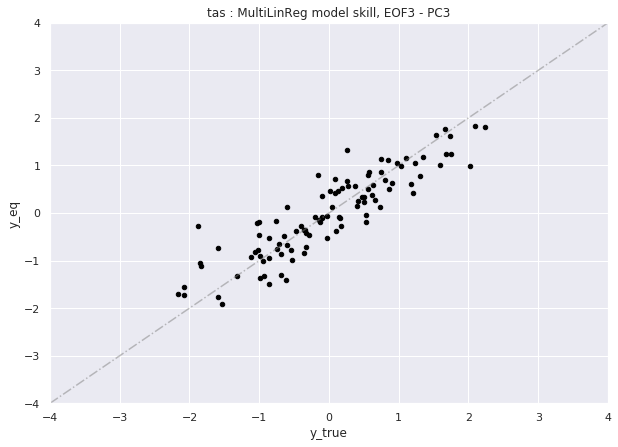

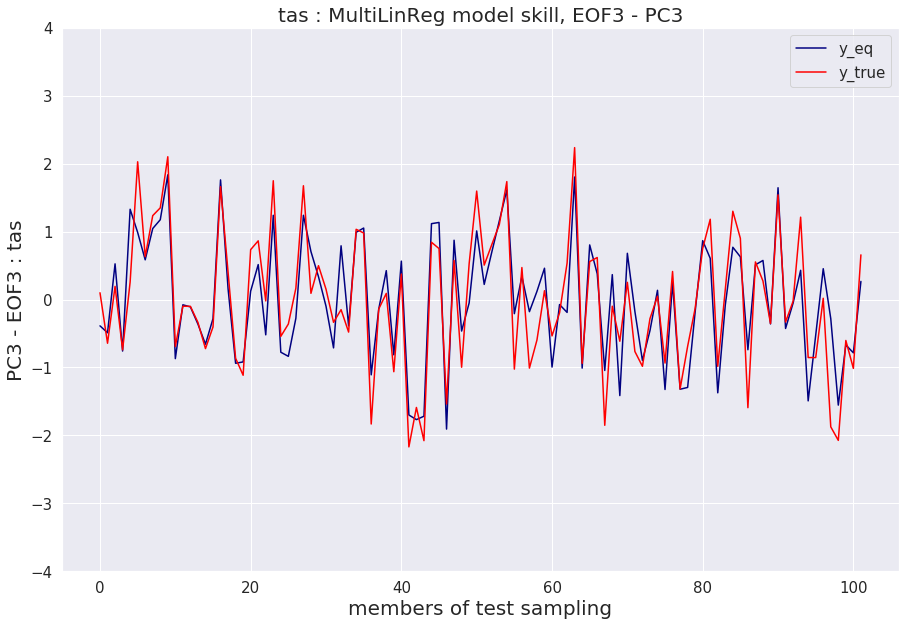

In [98]:
df = DFYeq
title = variable+' : MultiLinReg model skill, EOF3 - PC3'
xmin = -4
xmax = 4
ymin = -4
ymax = 4
name = 'MultiLinReg_'+variable+'_skill_pc3.png'

plot_model_skill(df, title, xmin, xmax, ymin, ymax, name)

xlabel = 'members of test sampling'
ylabel = 'PC3 - EOF3 : '+variable

plot_model_skill_lines(df, title, xlabel, ylabel, ymin, ymax)

In [99]:
LHS = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_param_standard.npy")

DFYpred = MultiLinReg_pred(LHS,X,y, param_names)
DFYpred

,y_pred,members
0,0.177104,102.0
1,-0.452515,103.0
2,-1.425103,104.0
3,-1.322137,105.0
4,2.477284,106.0
...,...,...
99995,-0.359346,100097.0
99996,-0.261631,100098.0
99997,-1.400953,100099.0
99998,-0.051014,100100.0


#### Save data

In [100]:
MultiLinReg_validation = DFYeq['y_eq'].values
MultiLinReg_prediction = DFYpred['y_pred'].values

# Save the predictionc in numpy arrays : 
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_validation_eof3_'+variable+'.npy', 
        MultiLinReg_validation)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_prediction_eof3_'+variable+'.npy', 
        MultiLinReg_prediction)

### EOF 4 - prediction

In [101]:
# Set the X and Y : Y = f(X)
X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
y = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF4pc_"+variable+".npy")
param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")

In [102]:
DFYeq = MultiLinReg_model(X,y,param_names, nb_p_list)
DFYeq

Intercept: 
 -0.003782369853818962
Coefficients: 
 [ 0.21112794 -0.00616401  0.1385007  -0.125886    0.05301258 -0.04110157
  0.00696637 -0.09597244 -0.20822056 -0.00327135 -0.01709991 -0.17382915
 -0.01126398  0.11718226 -0.50714794 -0.13442205 -0.0340815  -0.30488997
  0.0986907  -0.07077303  0.01535331  0.21431285 -0.27301148 -0.23119067
  0.01647082 -0.06690427 -0.05358617  0.02590009 -0.12783508 -0.24114343]
Score: 
 0.6628081676515603


,y_true,y_eq,members,members_0
0,0.586538,-0.094370,p311,0
1,-0.070027,-0.195295,p312,1
2,-0.498432,0.187689,p314,2
3,-1.025524,-0.453842,p316,3
4,0.863912,0.734319,p317,4
...,...,...,...,...
97,-1.371712,-1.357401,p465,97
98,-0.161396,-1.091396,p467,98
99,-1.124290,-0.246975,p469,99
100,-1.902700,-0.873698,p470,100


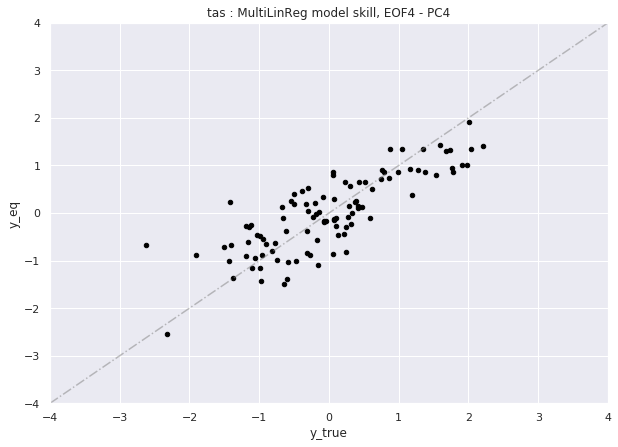

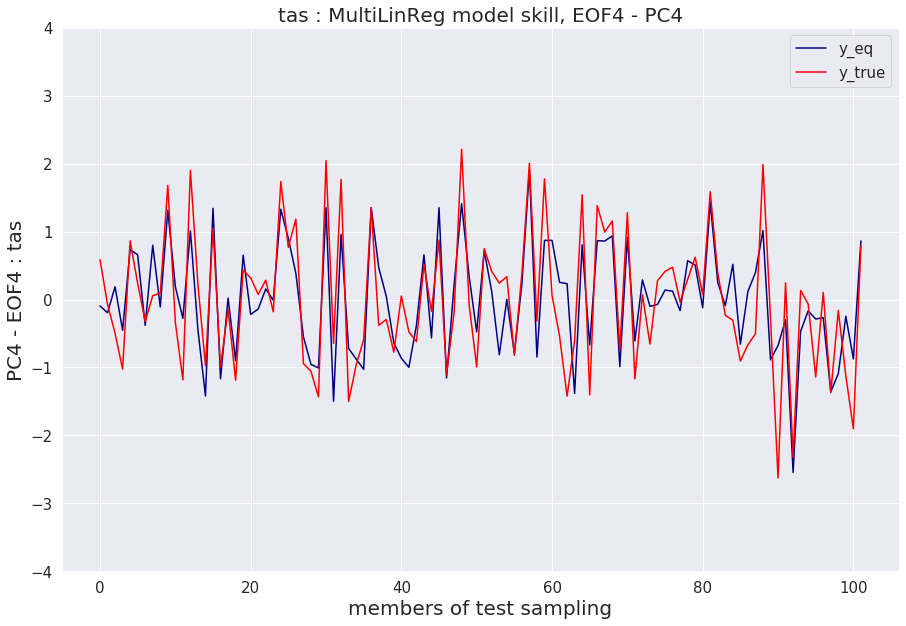

In [103]:
df = DFYeq
title = variable+' : MultiLinReg model skill, EOF4 - PC4'
xmin = -4
xmax = 4
ymin = -4
ymax = 4
name = 'MultiLinReg_'+variable+'_skill_pc4.png'

plot_model_skill(df, title, xmin, xmax, ymin, ymax, name)

xlabel = 'members of test sampling'
ylabel = 'PC4 - EOF4 : '+variable

plot_model_skill_lines(df, title, xlabel, ylabel, ymin, ymax)

In [104]:
LHS = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_param_standard.npy")

DFYpred = MultiLinReg_pred(LHS,X,y, param_names)
DFYpred

,y_pred,members
0,-0.866375,102.0
1,-1.409052,103.0
2,0.870567,104.0
3,-1.910633,105.0
4,0.208478,106.0
...,...,...
99995,0.372657,100097.0
99996,-0.588694,100098.0
99997,0.835653,100099.0
99998,-0.596886,100100.0


#### Save data

In [105]:
MultiLinReg_validation = DFYeq['y_eq'].values
MultiLinReg_prediction = DFYpred['y_pred'].values

# Save the predictionc in numpy arrays : 
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_validation_eof4_'+variable+'.npy', 
        MultiLinReg_validation)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_prediction_eof4_'+variable+'.npy', 
        MultiLinReg_prediction)

### EOF 5 - prediction

In [106]:
# Set the X and Y : Y = f(X)
X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
y = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF5pc_"+variable+".npy")
param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")

In [107]:
DFYeq = MultiLinReg_model(X,y,param_names, nb_p_list)
DFYeq

Intercept: 
 -0.0009605349726319044
Coefficients: 
 [ 0.36969045 -0.23611699 -0.0425696  -0.06395559  0.15775841 -0.60399363
 -0.07566723 -0.03823826 -0.12869711 -0.13380737  0.11408493 -0.07589178
  0.05490608  0.024958    0.30892746 -0.00099115 -0.08750587 -0.0228651
  0.00685277  0.11834725  0.01042373  0.01466698 -0.24283483 -0.04252093
  0.03698235  0.01074692 -0.07719805 -0.00773269 -0.11544853  0.06136352]
Score: 
 0.8268800951332851


,y_true,y_eq,members,members_0
0,1.931625,1.270425,p311,0
1,-1.880748,-1.311806,p312,1
2,1.072165,0.730384,p314,2
3,-1.134253,-0.609283,p316,3
4,0.866224,1.219861,p317,4
...,...,...,...,...
97,-0.314159,0.362578,p465,97
98,-0.380162,-1.089669,p467,98
99,-0.793313,-0.524068,p469,99
100,0.029599,0.405730,p470,100


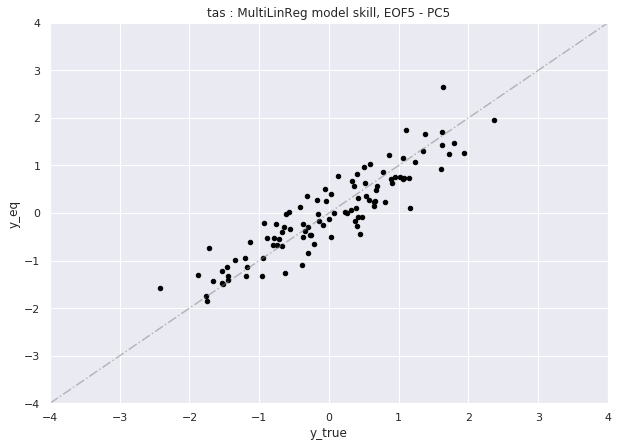

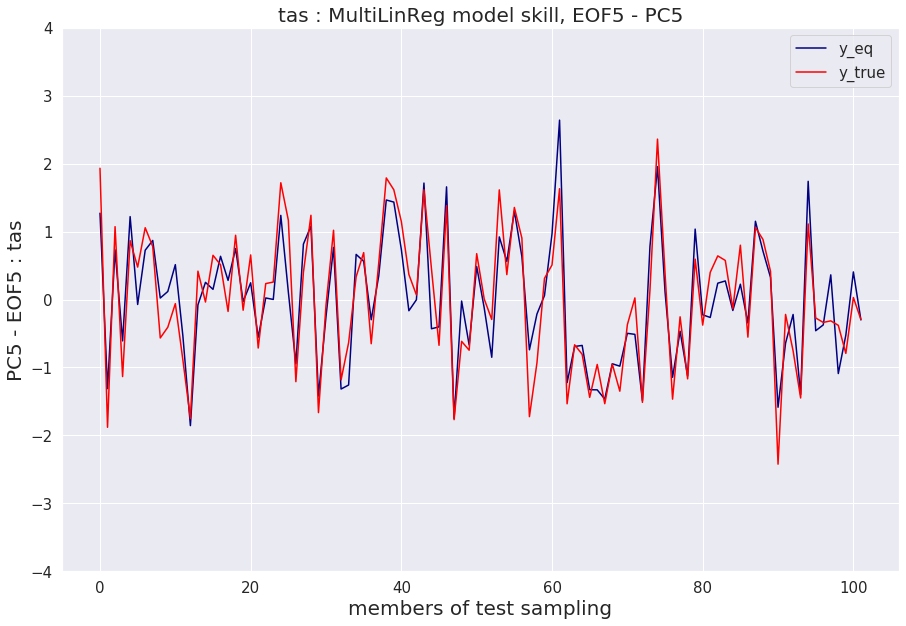

In [108]:
df = DFYeq
title = variable+' : MultiLinReg model skill, EOF5 - PC5'
xmin = -4
xmax = 4
ymin = -4
ymax = 4
name = 'MultiLinReg_'+variable+'_skill_pc5.png'

plot_model_skill(df, title, xmin, xmax, ymin, ymax, name)

xlabel = 'members of test sampling'
ylabel = 'PC5 - EOF5 : '+variable

plot_model_skill_lines(df, title, xlabel, ylabel, ymin, ymax)

In [109]:
LHS = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_param_standard.npy")

DFYpred = MultiLinReg_pred(LHS,X,y, param_names)
DFYpred

,y_pred,members
0,0.718467,102.0
1,0.870643,103.0
2,-0.249998,104.0
3,1.905300,105.0
4,-0.485037,106.0
...,...,...
99995,-1.266572,100097.0
99996,-0.560485,100098.0
99997,0.436110,100099.0
99998,0.884314,100100.0


#### Save data

In [110]:
MultiLinReg_validation = DFYeq['y_eq'].values
MultiLinReg_prediction = DFYpred['y_pred'].values

# Save the predictionc in numpy arrays : 
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_validation_eof5_'+variable+'.npy', 
        MultiLinReg_validation)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_prediction_eof5_'+variable+'.npy', 
        MultiLinReg_prediction)

### [Back to the top](#top)

# <a id="observation">Step 3 - Projection of observation dataset</a> </li>

In this section, we project the observations ($X_{obs}$) onto the EOFs calculated in [Step 1](#EOF). We call $U_{ens}$ the ensemble matrix of EOF amplitudes $w$ such as :  

$U_{ens} = \begin{pmatrix} 
                w_{1,1} & w_{2,1} & w_{3,1} & w_{4,1} & w_{5,1} \\ 
                ... & ... & ... & ... & ... \\
                w_{1,102} & w_{2,102} & w_{3,102} & w_{4,102} & w_{5,102}
           \end{pmatrix}$ 
           
           
<br>
<br>
<br>
The ensemble matrix of spatial patterns is called $v_{ens}$ and is expresses such as : 

$v_{ens} = \begin{pmatrix} 
                eof1(lat,lon)  \\ 
                eof2(lat,lon)  \\ 
                eof3(lat,lon)  \\ 
                eof4(lat,lon)  \\ 
                eof5(lat,lon)  \\ 
           \end{pmatrix}$ 


<br>

The EOF analysis can be expresses as : 
$X_{ens} = U_{ens} \cdot v_{ens}$

And we want the EOF amplitudes of the observations within this basis such as : 

$X_{obs} = U_{obs} \cdot v_{ens}$ 

$U_{obs} = X_{obs} \cdot {v_{ens}}^{-1}$

With : 

$U_{obs} = \begin{pmatrix} 
                o_{1,1} & o_{2,1} & o_{3,1} & o_{4,1} & o_{5,1} \\ 
                ... & ... & ... & ... & ... \\
                o_{1,102} & o_{2,102} & o_{3,102} & o_{4,102} & o_{5,102}
           \end{pmatrix}$ 

### Settings

In [5]:
product = 'BEST'
path_observation = '/data/home/globc/peatier/obs_data/BEST/'
filename = 'Land_and_Ocean_LatLong1_regrid_1979-1981.nc'
variable_obs = ['climatology', 'temperature']

In [6]:
#product = 'ERAi'
#path_observation = '/data/home/globc/peatier/obs_data/ERAI/'
#filename = 'tas_1m_197901_201812_ERAI_regrid.nc'
#variable_obs = 't2m'

### Functions

In [7]:
def load_monthly_clim(path, filename, variables) :
    
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    df=file[variables].to_dataframe()
    
    # Compute Climatological Annual Cycle :
    df1=df.reset_index(level=['time', 'lat', 'lon'])
    df1['year']=pd.DatetimeIndex(df1['time']).year
    df1['month']=pd.DatetimeIndex(df1['time']).month
    
    list_ind = []
    cpt=0
    for i in df1['year'] : 
        if i>1981 :
            list_ind.append(cpt)
            cpt+=1
        else : 
            cpt+=1
            
    df2 = df1.drop(list_ind)
    df_mean=df1.groupby(['month', 'lat', 'lon']).mean()
    df_mean=df_mean.drop(columns='year')
    
    return df_mean

In [8]:
def load_monthly_clim_BEST(path, filename, variables, time_ind) :
    
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    df1=file[variables[0]].to_dataframe()
    df1 = df1.reset_index(level=[time_ind[0]])
    df1_long = pd.concat([df1, df1, df1])
    
    df2=file[variables[1]].to_dataframe()
    df2 = df2.reset_index(level=[time_ind[1]])
    
    df2['ta'] = df2[variables[1]] + df1_long[variables[0]] +273.15
    df_obs = df2.drop(columns=[variables[1], time_ind[1]])
    
    return df_obs

In [9]:
def load_monthly_clim_BEST_clim(path, filename, variables) :
    
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    df1=file[variables].to_dataframe()
    df2 = df1.reset_index(['time', 'lat', 'lon'])
    df2[variables] = df2[variables] + 273.15
    df3 = df2.drop(columns= 'time')
    
    return df3

### Get the data 

In [10]:
Mean =  pd.read_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_'+variable+'_mean.npy').to_xarray().to_array()
Mean = Mean[0,:,:].rename({'variable':'mode'})
#Mean

In [11]:
eof1 = pd.read_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOFmap1_'+variable+'.npy').to_xarray().to_array()
eof2 = pd.read_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOFmap2_'+variable+'.npy').to_xarray().to_array()
eof3 = pd.read_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOFmap3_'+variable+'.npy').to_xarray().to_array()
eof4 = pd.read_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOFmap4_'+variable+'.npy').to_xarray().to_array()
eof5 = pd.read_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOFmap5_'+variable+'.npy').to_xarray().to_array()

eof1 = eof1[0,:,:].rename({'variable':'mode'})
eof2 = eof2[0,:,:].rename({'variable':'mode'})
eof3 = eof3[0,:,:].rename({'variable':'mode'})
eof4 = eof4[0,:,:].rename({'variable':'mode'})
eof5 = eof5[0,:,:].rename({'variable':'mode'})

eofs = [eof1,eof2,eof3,eof4,eof5]

eofs_combined = xr.combine_nested(eofs, concat_dim='eofs')

In [12]:
pc1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF1pc_'+variable+'.npy')
pc2 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF2pc_'+variable+'.npy')
pc3 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF3pc_'+variable+'.npy')
pc4 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF4pc_'+variable+'.npy')
pc5 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF5pc_'+variable+'.npy')

PC_df = pd.DataFrame(pc1)
PC_df['pc1'] = pc1
PC_df['pc2'] = pc2
PC_df['pc3'] = pc3
PC_df['pc4'] = pc4
PC_df['pc5'] = pc5
PC_df = PC_df.drop(labels = 0, axis=1)

#PC_df

In [13]:
# POUR LES OBSERVATIONS ERAI

#path = path_observation
#variables = [variable_obs]
#df_obs = load_monthly_clim(path, filename, variables)
#df_obs

In [14]:
# POUR LES OBSERVATIONS BEST

path = path_observation

file =  xr.open_mfdataset(path+filename,combine='by_coords')
clim = file['climatology'].to_dataframe()#.drop(columns='month_number')
clim = pd.concat([clim, clim, clim]).reset_index('month_number')

df_obs=file['temperature'].to_dataframe().reset_index('time')
df_obs['temperature'] = df_obs['temperature']
df_obs['clim'] = clim['climatology']+273.15
df_obs['ta'] = df_obs['temperature']+df_obs['clim']
variable_obs = 'ta'
df_obs

time  temperature        clim          ta
lat        lon                                                   
-88.927735 0.00000    1979.0     0.768801  247.956879  248.725677
           1.40625    1979.0     0.769734  247.934448  248.704178
           2.81250    1979.0     0.770550  247.913254  248.683807
           4.21875    1979.0     0.771259  247.893265  248.664520
           5.62500    1979.0     0.771860  247.873901  248.645767
...                      ...          ...         ...         ...
 88.927735 352.96875  1981.0     0.004460  242.438736  242.443192
           354.37500  1981.0    -0.004911  242.415558  242.410645
           355.78125  1981.0    -0.016334  242.421768  242.405441
           357.18750  1981.0    -0.024906  242.446747  242.421844
           358.59375  1981.0    -0.041427  242.496857  242.455429

[1179648 rows x 4 columns]

In [15]:
obs = df_obs.groupby(['lat','lon']).mean().to_xarray()
obs

<xarray.Dataset>
Dimensions:      (lat: 128, lon: 256)
Coordinates:
  * lat          (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon          (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
Data variables:
    time         (lat, lon) float64 1.98e+03 1.98e+03 ... 1.98e+03 1.98e+03
    temperature  (lat, lon) float32 0.17527 0.17550375 ... -0.16200545
    clim         (lat, lon) float32 226.26932 226.22813 ... 253.36414 253.36504
    ta           (lat, lon) float32 226.4446 226.40364 ... 253.20612 253.20302

### Comparison BEST and ERAi

In [385]:
#df_obs_ERAi = df_obs.groupby(['lat','lon']).mean().to_xarray()
#df_obs_ERAi

In [386]:
#df_obs_BEST = df_obs
#df_obs_BEST = df_obs_BEST.groupby(['lat','lon']).mean().to_xarray()
#df_obs_BEST

In [387]:
#data = df_obs_ERAi['t2m']

#title = "Temperature"
#label_min = 260
#label_max = 280

#data=df_obs['ta']
#lat = data['lat'][:]
#lon = data['lon'][:]

#fig = plt.figure(figsize=(10, 10))
#ax=plt.gca()

#ax.set_title('temperature', fontsize=18, fontweight = 'bold')

#m = Basemap(projection='robin',
#            lat_0=0.5*lat[-1], lon_0=-180.0, resolution='c')
#x, y = m(*np.meshgrid(lon,lat))


#cmap = plt.get_cmap('coolwarm',16)  # define the colormap, take the number of discrete colors you want

#m.pcolormesh(x,y,data,shading='gouraud',cmap=cmap)
#m.colorbar()
#cbar = m.colorbar(location='bottom', spacing = 'uniform', drawedges=True)
#cbar.set_label(' ', size = 16, style = 'italic')

#m.drawcoastlines()
#m.drawmapboundary()
#plt.clim(label_min, label_max)

# Show la figure .................
#plt.show()

In [388]:
#data = df_obs_BEST['ta']

#title = "Temperature"
#label_min = 260
#label_max = 280

#data=df_obs['ta']
#lat = data['lat'][:]
#lon = data['lon'][:]

#fig = plt.figure(figsize=(10, 10))
#ax=plt.gca()

#ax.set_title('temperature', fontsize=18, fontweight = 'bold')

#m = Basemap(projection='robin',
#            lat_0=0.5*lat[-1], lon_0=-180.0, resolution='c')
#x, y = m(*np.meshgrid(lon,lat))


#cmap = plt.get_cmap('coolwarm',16)  # define the colormap, take the number of discrete colors you want

#m.pcolormesh(x,y,data,shading='gouraud',cmap=cmap)
#m.colorbar()
#cbar = m.colorbar(location='bottom', spacing = 'uniform', drawedges=True)
#cbar.set_label(' ', size = 16, style = 'italic')

#m.drawcoastlines()
#m.drawmapboundary()
#plt.clim(label_min, label_max)

# Show la figure .................
#plt.show()

In [390]:
#data = df_obs_ERAi['t2m'] - df_obs_BEST['ta']

#title = "Temperature Difference [ERAi - BEST]"
#label_min = -2
#label_max = 2

#data=df_obs['ta']
#lat = data['lat'][:]
#lon = data['lon'][:]

#fig = plt.figure(figsize=(10, 10))
#ax=plt.gca()

#ax.set_title('temperature', fontsize=18, fontweight = 'bold')

#m = Basemap(projection='robin',
#            lat_0=0.5*lat[-1], lon_0=-180.0, resolution='c')
#x, y = m(*np.meshgrid(lon,lat))


#cmap = plt.get_cmap('coolwarm',16)  # define the colormap, take the number of discrete colors you want

#m.pcolormesh(x,y,data,shading='gouraud',cmap=cmap)
#m.colorbar()
#cbar = m.colorbar(location='bottom', spacing = 'uniform', drawedges=True)
#cbar.set_label(' ', size = 16, style = 'italic')

#m.drawcoastlines()
#m.drawmapboundary()
#plt.clim(label_min, label_max)

# Show la figure .................
#plt.show()

### Compute anomalies 

In [16]:
X_obs = obs[variable_obs] - Mean
X_obs_bis = X_obs.expand_dims(dim={'dummy':range(0,102,1)})
#X_obs_bis

### Inverse the EOF matrix $v_{ens}$

In [17]:
eofs_inv = np.linalg.pinv(eofs_combined.transpose())
#eofs_inv = xr.DataArray(eofs_inv, dims=['eofs','lon','lat'])
#eofs_inv

### Compute $U_{obs}$

In [18]:
U_obs = np.dot(eofs_inv,X_obs_bis.transpose('lon','lat', 'dummy'))
#U_ens = U_ens.mean(dim=['lat','lon'])#.transpose()
#U_obs

In [19]:
U_obs = xr.DataArray(U_obs, dims=['lon','eofs','lon2', 'dummy'])
U_obs_avg = U_obs[0,:,0,0].transpose()
U_obs_avg

<xarray.DataArray (eofs: 5)>
array([-0.09274242, -1.3749883 , -0.09347625,  1.5416942 ,  3.8224268 ],
      dtype=float32)
Dimensions without coordinates: eofs

### Save data

In [20]:
#Save the U_obs_avg 
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_obs_'+variable+'_'+product+'.npy', U_obs_avg)

### [Back to the top](#top)

# Projection of CFMIP data

In [148]:
def load_monthly_clim(path, filename, variables) :
    
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    df=file[variables].to_dataframe()
    
    # Compute Climatological Annual Cycle :
    df1=df.reset_index(level=['time', 'lat', 'lon'])
    df1['month']=pd.DatetimeIndex(df1['time']).month # time in years
    df_mean=df1.groupby(['month', 'lat', 'lon']).mean()
    
    return df_mean

In [149]:
# Download the amip dataframes and compute the radiative budget  

path = "/data/scratch/globc/peatier/CMIP6/CNRM-CM6-1/CFMIP/amip/"
filename = "*_amip_*.nc"
CNRM_amip = load_monthly_clim(path, filename, variables)

path = "/data/scratch/globc/peatier/CMIP6/MRI-ESM2-0/amip/"
MRI_amip = load_monthly_clim(path, filename, variables)

path = "/data/scratch/globc/peatier/CMIP6/CanESM5/amip/"
filename = "standard_*_amip_*regrid.nc"
CAN_amip = load_monthly_clim(path, filename, variables)
CAN_amip

path = "/data/scratch/globc/peatier/CMIP6/MIROC6/"
filename = "*_amip_*regrid.nc"
MIROC_amip = load_monthly_clim(path, filename, variables)
MIROC_amip

path = "/data/scratch/globc/peatier/CMIP6/HadGEM3-GC31-LL/"
filename = "standard_*_amip_*regrid.nc"
HadGEM3_amip = load_monthly_clim(path, filename, variables)
HadGEM3_amip

path = "/data/scratch/globc/peatier/CMIP6/IPSL-CM6A-LR/"
filename = "*_amip_*regrid.nc"
IPSL_amip = load_monthly_clim(path, filename, variables)
IPSL_amip

path = "/data/scratch/globc/peatier/CMIP6/BCC-CSM2-MR/"
filename = "standard_*_amip_*regrid.nc"
BCC_amip = load_monthly_clim(path, filename, variables)
BCC_amip

tas  height
month lat        lon                          
1     -88.927735 0.00000    247.238327     2.0
                 1.40625    247.209213     2.0
                 2.81250    247.179489     2.0
                 4.21875    247.150101     2.0
                 5.62500    247.120407     2.0
...                                ...     ...
12     88.927735 352.96875  246.398361     2.0
                 354.37500  246.412842     2.0
                 355.78125  246.424255     2.0
                 357.18750  246.430847     2.0
                 358.59375  246.445908     2.0

[393216 rows x 2 columns]

In [150]:
df_obs = pd.DataFrame()
df_obs['CNRM'] = CNRM_amip[variables[0]]
df_obs['MRI'] = MRI_amip[variables[0]]
df_obs['CAN'] = CAN_amip[variables[0]]
df_obs['MIROC'] = MIROC_amip[variables[0]]
df_obs['HadGEM3'] = HadGEM3_amip[variables[0]]
df_obs['IPSL'] = IPSL_amip[variables[0]]
df_obs['BCC'] = BCC_amip[variables[0]]
#df_obs = df_obs.drop(['rsut', 'height'], axis = 1)
df_obs

CNRM         MRI         CAN       MIROC  \
month lat        lon                                                         
1     -88.927735 0.00000    246.359619  248.840958  250.801117  258.720856   
                 1.40625    246.359619  248.798264  250.800552  258.696228   
                 2.81250    246.359619  248.756699  250.616211  258.671844   
                 4.21875    246.359619  248.714081  250.615662  258.646667   
                 5.62500    246.359619  248.680939  250.615112  258.620300   
...                                ...         ...         ...         ...   
12     88.927735 352.96875  247.806992  246.397644  245.186737  242.919815   
                 354.37500  247.806992  246.398926  245.298721  242.933517   
                 355.78125  247.806992  246.401794  245.299011  242.946350   
                 357.18750  247.806992  246.404037  245.401749  242.956711   
                 358.59375  247.806992  246.405579  245.402039  242.969666   

                               HadGEM3        IPSL         BCC  
month lat        lon                                            
1     -88.927735 0.00000    251.111130  245.918213  247.238327  
                 1.40625    251.096207  245.889923  247.209213  
                 2.81250    251.082642  245.859909  247.179489  
                 4.21875    251.067566  245.823822  247.150101  
                 5.62500    251.054047  245.789490  247.120407  
...                                ...         ...         ...  
12     88.927735 352.96875  246.128754  246.175323  246.398361  
                 354.37500  246.147369  246.209091  246.412842  
                 355.78125  246.162262  246.229935  246.424255  
                 357.18750  246.173904  246.240448  246.430847  
                 358.59375  246.186951  246.257736  246.445908  

[393216 rows x 7 columns]

In [151]:
obs = df_obs.groupby(['lat','lon']).mean().to_xarray()
obs

<xarray.Dataset>
Dimensions:  (lat: 128, lon: 256)
Coordinates:
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
Data variables:
    CNRM     (lat, lon) float32 224.74423 224.74423 ... 255.80571 255.80571
    MRI      (lat, lon) float32 227.22346 227.19633 ... 257.99255 257.9961
    CAN      (lat, lon) float32 229.76595 229.76503 ... 255.69073 255.6909
    MIROC    (lat, lon) float32 230.20848 230.16988 ... 256.15683 256.1647
    HadGEM3  (lat, lon) float32 227.70825 227.68709 ... 257.15543 257.1644
    IPSL     (lat, lon) float32 224.32076 224.26884 ... 257.17487 257.18286
    BCC      (lat, lon) float32 228.98434 228.92908 ... 257.7885 257.7963

## Compute Anomaly

In [152]:
X_obs = {}
X_obs['CNRM'] = obs['CNRM'] - Mean
X_obs['MRI'] = obs['MRI'] - Mean
X_obs['CAN'] = obs['CAN'] - Mean
X_obs['MIROC'] = obs['MIROC'] - Mean
X_obs['HadGEM3'] = obs['HadGEM3'] - Mean
X_obs['IPSL'] = obs['IPSL'] - Mean
X_obs['BCC'] = obs['BCC'] - Mean
X_obs

{'CNRM': <xarray.DataArray (lat: 128, lon: 256)>
 array([[-0.7200928, -0.7200928, -0.7200928, ..., -0.7200928, -0.7200928,
         -0.7200928],
        [-1.0602112, -1.0602112, -1.0602112, ..., -1.0602112, -1.0602112,
         -1.0602112],
        [-1.1203308, -1.1203308, -1.1203308, ..., -1.087143 , -1.1203308,
         -1.1203308],
        ...,
        [ 1.4942322,  1.4942322,  1.4942322, ...,  1.4111633,  1.4942322,
          1.4942322],
        [ 1.6632996,  1.6632996,  1.6632996, ...,  1.6632996,  1.6632996,
          1.6632996],
        [ 1.5664062,  1.5664062,  1.5664062, ...,  1.5664062,  1.5664062,
          1.5664062]], dtype=float32)
 Coordinates:
   * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
   * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
     mode     <U7 'tasmean', 'MRI': <xarray.DataArray (lat: 128, lon: 256)>
 array([[ 1.75914   ,  1.7320099 ,  1.7044983 , ...,  1.8387604 ,
          1.8123322 ,  1.7840576 ]

## Trouver U_obs

In [153]:
eofs_inv = np.linalg.pinv(eofs_combined.transpose())
#eofs_inv = xr.DataArray(eofs_inv, dims=['eofs','lon','lat'])
#eofs_inv

In [154]:
X_CNRM_bis = X_obs['CNRM'].expand_dims(dim={'dummy':range(0,102,1)})
X_MRI_bis = X_obs['MRI'].expand_dims(dim={'dummy':range(0,102,1)})
X_CAN_bis = X_obs['CAN'].expand_dims(dim={'dummy':range(0,102,1)})
X_MIROC_bis = X_obs['MIROC'].expand_dims(dim={'dummy':range(0,102,1)})
X_HadGEM3_bis = X_obs['HadGEM3'].expand_dims(dim={'dummy':range(0,102,1)})
X_IPSL_bis = X_obs['IPSL'].expand_dims(dim={'dummy':range(0,102,1)})
X_BCC_bis = X_obs['BCC'].expand_dims(dim={'dummy':range(0,102,1)})

In [155]:
U_CNRM = np.dot(eofs_inv,X_CNRM_bis.transpose('lon','lat', 'dummy'))
U_MRI = np.dot(eofs_inv,X_MRI_bis.transpose('lon','lat', 'dummy'))
U_CAN = np.dot(eofs_inv,X_CAN_bis.transpose('lon','lat', 'dummy'))
U_MIROC = np.dot(eofs_inv,X_MIROC_bis.transpose('lon','lat', 'dummy'))
U_HadGEM3 = np.dot(eofs_inv,X_HadGEM3_bis.transpose('lon','lat', 'dummy'))
U_IPSL = np.dot(eofs_inv,X_IPSL_bis.transpose('lon','lat', 'dummy'))
U_BCC = np.dot(eofs_inv,X_BCC_bis.transpose('lon','lat', 'dummy'))


In [156]:
U_CNRM = xr.DataArray(U_CNRM, dims=['lon','eofs','lon2', 'dummy'])
U_CNRM_avg = U_CNRM[0,:,0,0].transpose()

U_MRI = xr.DataArray(U_MRI, dims=['lon','eofs','lon2', 'dummy'])
U_MRI_avg = U_MRI[0,:,0,0].transpose()

U_CAN = xr.DataArray(U_CAN, dims=['lon','eofs','lon2', 'dummy'])
U_CAN_avg = U_CAN[0,:,0,0].transpose()

U_MIROC = xr.DataArray(U_MIROC, dims=['lon','eofs','lon2', 'dummy'])
U_MIROC_avg = U_MIROC[0,:,0,0].transpose()

U_HadGEM3 = xr.DataArray(U_HadGEM3, dims=['lon','eofs','lon2', 'dummy'])
U_HadGEM3_avg = U_HadGEM3[0,:,0,0].transpose()

U_IPSL = xr.DataArray(U_IPSL, dims=['lon','eofs','lon2', 'dummy'])
U_IPSL_avg = U_IPSL[0,:,0,0].transpose()

U_BCC = xr.DataArray(U_BCC, dims=['lon','eofs','lon2', 'dummy'])
U_BCC_avg = U_BCC[0,:,0,0].transpose()

In [157]:
#Save the U_obs_avg 
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_CNRM_tas.npy', U_CNRM_avg)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_MRI_tas.npy', U_MRI_avg)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_CAN_tas.npy', U_CAN_avg)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_MIROC_tas.npy', U_MIROC_avg)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_HadGEM3_tas.npy', U_HadGEM3_avg)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_IPSL_tas.npy', U_IPSL_avg)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_BCC_tas.npy', U_BCC_avg)

### [Back to the top](#top)

# <a id="RMSE">Step 4 - RMSE estimate</a> </li>

The model error as compared to observations is calculated by comparing the EOF amplitudes $w$ in each member with the projection of the observations $o$ on the model EOF basis through a Root Mean Square Error (RMSE). For a given member of the PPE, the error associated with the variable $s$ is : 

\begin{equation}
    E_{s} = \sqrt{\Sigma_i^N \frac{(w_{is}-o_{is})^2}{N}}
\end{equation}

with $i$ varying from $1$ to $N$, the number of modes considered. In the present study, we truncated the EOF after the 5th mode for each variable : $N=5$.

### Settings

In [5]:
product = 'BEST'
ylabel = '$E_{tas}$ (K)'

### Functions

In [6]:
def Error_emulator(pc1, pc2, pc3, pc4, pc5, variable):
    U_obs = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_obs_'+variable+'_'+product+'.npy')
    E_tmp = (pc1-U_obs[0])**2 + (pc2-U_obs[1])**2 + (pc3-U_obs[2])**2 + (pc4-U_obs[3])**2 + (pc5-U_obs[4])**2
    E = sqrt(E_tmp/5)
    return E

In [7]:
def Error(path, filename, U_obs):
    
    U = np.load(path+filename)

    pc1 = U[0]
    pc2 = U[1]
    pc3 = U[2]
    pc4 = U[3]
    pc5 = U[4]

    E_tmp = (pc1-U_obs[0])**2 + (pc2-U_obs[1])**2 + (pc3-U_obs[2])**2 + (pc4-U_obs[3])**2 + (pc5-U_obs[4])**2
    E = sqrt(E_tmp/5)
    return E

In [8]:
def RMSE_emulator(pc1, pc2, pc3, pc4, pc5, variable) : 
    
    U_obs = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_obs_'+variable+'_'+product+'.npy')
    
    E_pc1 = []
    E_pc2 = []
    E_pc3 = []
    E_pc4 = []
    E_pc5 = []
    E_tmp = []

    for i in pc1:
        tmp = (i-U_obs[0])**2
        E_pc1.append(tmp)
    
    for j in pc2:
        tmp = (j-U_obs[1])**2
        E_pc2.append(tmp)

    for k in pc3:
        tmp = (k-U_obs[2])**2
        E_pc3.append(tmp)
    
    for l in pc4:
        tmp = (l-U_obs[3])**2
        E_pc4.append(tmp)
    
    for m in pc5:
        tmp = (m-U_obs[4])**2
        E_pc5.append(tmp)

    for n in range(0,len(E_pc1),1) :    
        tmp = E_pc1[n]+E_pc2[n]+E_pc3[n]+E_pc4[n]+E_pc5[n]
        E_tmp.append(tmp/5)

    
    E = sqrt(E_tmp)
    
    
    return E

### Get the data 

In [9]:
U_obs = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_obs_'+variable+'_'+product+'.npy')

pc1_obs = U_obs[0]
pc2_obs = U_obs[1]
pc3_obs = U_obs[2]
pc4_obs = U_obs[3]
pc5_obs = U_obs[4]

### p1 default model

In [10]:
pc1_p1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/p1_EOF1pc_'+variable+'.npy')
pc2_p1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/p1_EOF2pc_'+variable+'.npy')
pc3_p1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/p1_EOF3pc_'+variable+'.npy')
pc4_p1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/p1_EOF4pc_'+variable+'.npy')
pc5_p1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/p1_EOF5pc_'+variable+'.npy')

p1_feedbacks = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks_p1.npy')

In [11]:
E_p1_tmp = (pc1_p1-pc1_obs)**2 + (pc2_p1-pc2_obs)**2 + (pc3_p1-pc3_obs)**2 + (pc4_p1-pc4_obs)**2 + (pc5_p1-pc5_obs)**2
E_p1 = sqrt(E_p1_tmp/5)
        
print(E_p1)

2.0801795883743956


### CMIP6 models

In [12]:
path = '/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/'

filename = 'U_MRI_'+variable+'.npy'
E_MRI = Error(path, filename, U_obs)

filename = 'U_CAN_'+variable+'.npy'
E_CAN = Error(path, filename, U_obs)

filename = 'U_MIROC_'+variable+'.npy'
E_MIROC = Error(path, filename, U_obs)

filename = 'U_HadGEM3_'+variable+'.npy'
E_HadGEM3 = Error(path, filename, U_obs)

filename = 'U_IPSL_'+variable+'.npy'
E_IPSL = Error(path, filename, U_obs)

filename = 'U_BCC_'+variable+'.npy'
E_BCC = Error(path, filename, U_obs)

### PPE

In [13]:
eof1 = pd.read_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOFmap1_'+variable+'.npy').to_xarray().to_array()
eof2 = pd.read_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOFmap2_'+variable+'.npy').to_xarray().to_array()
eof3 = pd.read_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOFmap3_'+variable+'.npy').to_xarray().to_array()
eof4 = pd.read_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOFmap4_'+variable+'.npy').to_xarray().to_array()
eof5 = pd.read_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOFmap5_'+variable+'.npy').to_xarray().to_array()

eof1 = eof1[0,:,:].rename({'variable':'mode'})
eof2 = eof2[0,:,:].rename({'variable':'mode'})
eof3 = eof3[0,:,:].rename({'variable':'mode'})
eof4 = eof4[0,:,:].rename({'variable':'mode'})
eof5 = eof5[0,:,:].rename({'variable':'mode'})

In [14]:
pc1_PPE = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF1pc_'+variable+'.npy')
pc2_PPE = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF2pc_'+variable+'.npy')
pc3_PPE = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF3pc_'+variable+'.npy')
pc4_PPE = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF4pc_'+variable+'.npy')
pc5_PPE = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF5pc_'+variable+'.npy')

PC_df_PPE = pd.DataFrame(pc1_PPE)
PC_df_PPE['pc1'] = pc1_PPE
PC_df_PPE['pc2'] = pc2_PPE
PC_df_PPE['pc3'] = pc3_PPE
PC_df_PPE['pc4'] = pc4_PPE
PC_df_PPE['pc5'] = pc5_PPE
PC_df_PPE = PC_df_PPE.drop(labels = 0, axis=1)
PC_df_PPE

,pc1,pc2,pc3,pc4,pc5
0,-1.037732,-1.772081,0.099338,0.586538,1.931625
1,0.500078,0.633004,-0.643880,-0.070027,-1.880748
2,1.538930,-0.967792,0.192939,-0.498432,1.072165
3,0.524819,-1.622346,-0.740827,-1.025524,-1.134253
4,0.683105,0.110459,0.257606,0.863912,0.866224
...,...,...,...,...,...
97,1.117563,-0.113455,-1.874182,-1.371712,-0.314159
98,-0.847133,2.220053,-2.073222,-0.161396,-0.380162
99,-0.200386,1.630405,-0.603055,-1.124290,-0.793313
100,1.692824,0.389283,-1.014095,-1.902700,0.029599


In [15]:
E_PPE = RMSE_emulator(pc1_PPE, pc2_PPE, pc3_PPE, pc4_PPE, pc5_PPE, variable)
E_PPE

array([1.05596599, 2.82171071, 1.71092106, 2.53064876, 1.55757963,
       2.2058314 , 1.56937605, 1.73494687, 2.47342061, 2.13471877,
       2.1557799 , 2.49233573, 2.61307049, 1.77071465, 2.17166139,
       1.45919173, 2.56912106, 2.49330866, 2.10855312, 2.41838355,
       1.63197904, 2.30799914, 1.80823006, 2.50919144, 1.14520688,
       1.35640359, 2.63271936, 2.37560647, 1.65077045, 2.80386532,
       2.06399052, 1.89439237, 2.48064573, 2.66233508, 2.19266651,
       1.79215892, 2.18271306, 1.87848026, 1.49557493, 1.87981379,
       1.44482799, 2.03435255, 2.0973089 , 1.86314371, 1.74833334,
       2.12097444, 1.76156429, 2.85246517, 2.1667172 , 2.20990225,
       2.18632839, 2.05090239, 1.98280239, 1.37498952, 1.83287967,
       2.21577418, 1.5760375 , 2.60606104, 2.4289298 , 1.95915475,
       2.05761108, 1.61562437, 2.84919852, 2.69595447, 2.16620107,
       2.9483726 , 2.4952773 , 2.68201944, 2.40731338, 2.64705869,
       2.18574597, 2.27547176, 2.61240461, 2.14281024, 1.04127

### Multi-Linear Regression predictions

In [16]:
pc1_pred = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_prediction_eof1_'+variable+'.npy')
pc2_pred = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_prediction_eof2_'+variable+'.npy')
pc3_pred = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_prediction_eof3_'+variable+'.npy')
pc4_pred = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_prediction_eof4_'+variable+'.npy')
pc5_pred = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_prediction_eof5_'+variable+'.npy')

PC_df = pd.DataFrame(pc1_pred)
PC_df['pc1'] = pc1_pred
PC_df['pc2'] = pc2_pred
PC_df['pc3'] = pc3_pred
PC_df['pc4'] = pc4_pred
PC_df['pc5'] = pc5_pred
PC_df = PC_df.drop(labels = 0, axis=1)
#PC_df

pc1_pred = PC_df['pc1'].to_xarray().rename({'index':'mode'})
pc2_pred = PC_df['pc2'].to_xarray().rename({'index':'mode'})
pc3_pred = PC_df['pc3'].to_xarray().rename({'index':'mode'})
pc4_pred = PC_df['pc4'].to_xarray().rename({'index':'mode'})
pc5_pred = PC_df['pc5'].to_xarray().rename({'index':'mode'})

In [17]:
pc1_val = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_validation_eof1_'+variable+'.npy')
pc2_val = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_validation_eof2_'+variable+'.npy')
pc3_val = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_validation_eof3_'+variable+'.npy')
pc4_val = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_validation_eof4_'+variable+'.npy')
pc5_val = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_validation_eof5_'+variable+'.npy')

PC_val_df = pd.DataFrame(pc1_val)
PC_val_df['pc1'] = pc1_val
PC_val_df['pc2'] = pc2_val
PC_val_df['pc3'] = pc3_val
PC_val_df['pc4'] = pc4_val
PC_val_df['pc5'] = pc5_val
PC_val_df = PC_val_df.drop(labels = 0, axis=1)
#PC_df

pc1_val = PC_val_df['pc1'].to_xarray().rename({'index':'mode'})
pc2_val = PC_val_df['pc2'].to_xarray().rename({'index':'mode'})
pc3_val = PC_val_df['pc3'].to_xarray().rename({'index':'mode'})
pc4_val = PC_val_df['pc4'].to_xarray().rename({'index':'mode'})
pc5_val = PC_val_df['pc5'].to_xarray().rename({'index':'mode'})

In [18]:
E_multilinreg_val = RMSE_emulator(pc1_val, pc2_val, pc3_val, pc4_val, pc5_val, variable)
E_multilinreg_val

array([1.47018798, 2.55015193, 1.75446856, 2.20658874, 1.54419758,
       2.20802381, 1.67731727, 1.62186921, 2.29248056, 1.87147433,
       1.81832995, 2.20426445, 2.62881739, 2.02353227, 2.17345365,
       1.69431689, 2.36569723, 2.36427428, 2.17876626, 2.3286487 ,
       1.81186476, 2.20177141, 1.87367534, 2.52031601, 1.45512654,
       1.81413988, 2.62669346, 2.10393375, 1.71303   , 2.61635268,
       2.10258356, 2.116687  , 2.50469809, 2.71126324, 2.15149848,
       1.9355043 , 1.95495014, 1.85376721, 1.60966245, 1.87376241,
       1.86118285, 2.27811451, 2.09145814, 1.58535291, 2.21010874,
       2.05167617, 1.77126324, 2.7658377 , 1.76471049, 2.12795937,
       2.12152965, 2.07464886, 2.22461638, 1.79790829, 1.80005465,
       2.12581374, 1.65479785, 2.06741742, 2.2668548 , 2.06806013,
       1.80680685, 1.08783943, 2.45874586, 2.77596548, 2.16862739,
       2.79236781, 2.59035719, 2.63631376, 2.37900062, 2.59453818,
       2.24744771, 2.36129912, 2.55971445, 1.90691566, 1.21970

In [19]:
E_multilinreg_pred = RMSE_emulator(pc1_pred, pc2_pred, pc3_pred, pc4_pred, pc5_pred, variable)
E_multilinreg_pred

array([1.96949773, 2.08159966, 2.05547913, ..., 1.95425845, 2.25184707,
       1.13537416])

### Get the feedbacks

In [20]:
Fdbck_PPE = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks.npy")
Fdbck_multilinreg_val = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_validation_FdbckN.npy")
Fdbck_multilinreg_pred = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_prediction_FdbckN.npy")

Fdbck_CFMIP = np.load(file='/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/CMIP6_NetFeedbcks.npy')
Fdbck_MRI = Fdbck_CFMIP[1]
Fdbck_CAN = Fdbck_CFMIP[2]
Fdbck_MIROC = Fdbck_CFMIP[3]
Fdbck_HadGEM3 = Fdbck_CFMIP[4]
Fdbck_IPSL = Fdbck_CFMIP[5]
Fdbck_BCC = Fdbck_CFMIP[6]

In [21]:
E_PPE_df = pd.DataFrame(E_PPE, columns=['E_PPE'])
E_PPE_df['Fdbck'] = Fdbck_PPE

In [22]:
E_multilinreg_val_df = pd.DataFrame(E_multilinreg_val, columns=['E_multilinreg_val'])
E_multilinreg_val_df['Fdbck_val'] = Fdbck_multilinreg_val

E_multilinreg_pred_df = pd.DataFrame(E_multilinreg_pred[0:100000], columns=['E_multilinreg_pred'])
E_multilinreg_pred_df['Fdbck_pred'] = Fdbck_multilinreg_pred
#E_multilinreg_pred_df

### Plotting

In [23]:
E_PPE_df_BEST = E_PPE_df
E_multilinreg_pred_df_BEST = E_multilinreg_pred_df

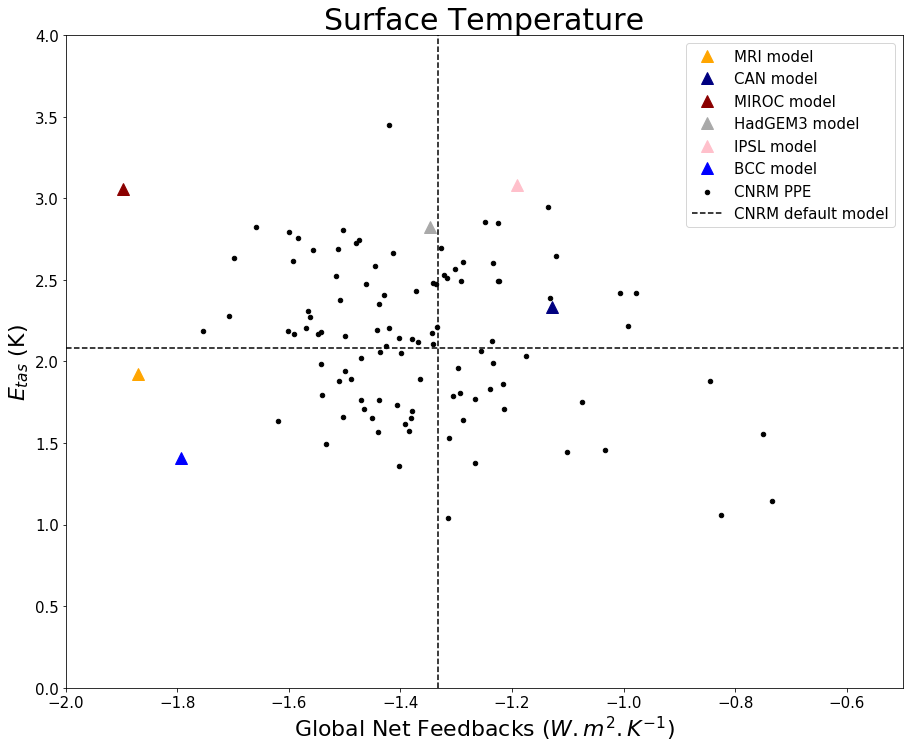

In [24]:
ax = plt.gca()

E_PPE_df_BEST.plot(kind='scatter', x='Fdbck', y='E_PPE', color='black', figsize=(15, 12), 
                     marker="o", ax = ax)
#E_PPE_df_ERAi.plot(kind='scatter', x='Fdbck', y='E_PPE', color='red', figsize=(15, 12), 
#                     marker="o", ax = ax)
plt.plot(Fdbck_MRI, E_MRI, color='orange', marker='^', linewidth=0, markersize=12)
plt.plot(Fdbck_CAN, E_CAN, color='navy', marker='^', linewidth=0, markersize=12)
plt.plot(Fdbck_MIROC, E_MIROC, color='darkred', marker='^', linewidth=0, markersize=12)
plt.plot(Fdbck_HadGEM3, E_HadGEM3, color='darkgray', marker='^', linewidth=0, markersize=12)
plt.plot(Fdbck_IPSL, E_IPSL, color='pink', marker='^', linewidth=0, markersize=12)
plt.plot(Fdbck_BCC, E_BCC, color='blue', marker='^', linewidth=0, markersize=12)


plt.hlines(E_p1,xmin = -2.0,xmax = 2.0,label='default simulation', colors='black', 
           linestyles='dashed')
plt.vlines(p1_feedbacks,ymin = 0,ymax = 25,label='default simulation', colors='black', 
           linestyles='dashed')

legend = ['MRI model', 'CAN model', 'MIROC model', 'HadGEM3 model', 'IPSL model',
          'BCC model', 'CNRM PPE', 'CNRM default model']

title = TITLE
plt.xlabel('Global Net Feedbacks ($W.m^2.K^{-1}$)', fontsize=22)
plt.ylabel(ylabel, fontsize=22)
plt.legend(legend, fontsize=15)
plt.title(title, fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylim(0,4)
plt.xlim(-2.0,-0.5)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/RMSE_"+variable+"_PPE.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

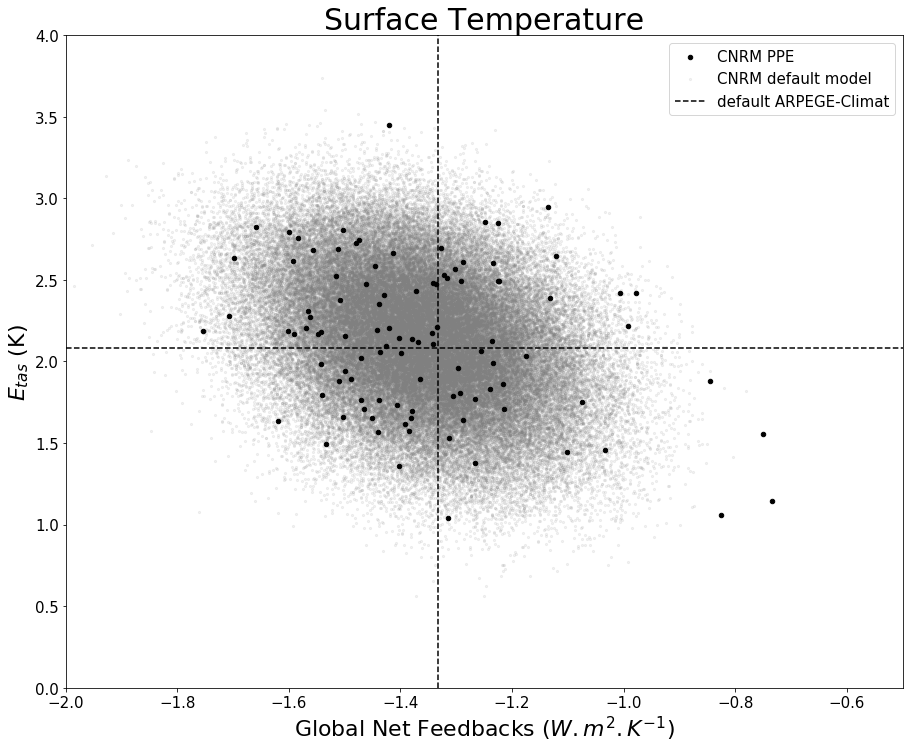

In [25]:
ax = plt.gca()

#plt.plot(Fdbck_MRI, E_MRI, color='orange', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_CAN, E_CAN, color='navy', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_MIROC, E_MIROC, color='darkred', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_HadGEM3, E_HadGEM3, color='darkgray', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_IPSL, E_IPSL, color='pink', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_BCC, E_BCC, color='blue', marker='^', linewidth=0, markersize=12)


E_PPE_df_BEST.plot(kind='scatter', x='Fdbck', y='E_PPE', color='black', figsize=(15, 12), 
                     marker="o", ax = ax)
#E_PPE_df_ERAi.plot(kind='scatter', x='Fdbck', y='E_PPE', color='blue', figsize=(15, 12), 
#                     marker="o", ax = ax)

E_multilinreg_pred_df_BEST.plot(kind='scatter', x='Fdbck_pred', y='E_multilinreg_pred', 
                           color='gray', alpha=0.1, figsize=(15, 12), marker='.', zorder=0, ax = ax)
#E_multilinreg_pred_df_BERAi.plot(kind='scatter', x='Fdbck_pred', y='E_multilinreg_pred', 
#                           color='cornflowerblue', alpha=0.1, figsize=(15, 12), marker='.', zorder=0, ax = ax)

plt.hlines(E_p1,xmin = -2.0,xmax = 2.0,label='default simulation', colors='black', 
           linestyles='dashed')
#plt.hlines(E_p1_ERAi,xmin = -2.0,xmax = 2.0,label='default simulation', colors='navy', 
#           linestyles='dashed')
plt.vlines(p1_feedbacks,ymin = 0,ymax = 25,label='default simulation', colors='black', 
           linestyles='dashed')

legend = ['CNRM PPE', 'CNRM default model', 'default ARPEGE-Climat']

title = TITLE
plt.xlabel('Global Net Feedbacks ($W.m^2.K^{-1}$)', fontsize=22)
plt.ylabel(ylabel, fontsize=22)
plt.legend(legend, fontsize=15)
plt.title(title, fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylim(0,4)
plt.xlim(-2.0,-0.5)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/RMSE_"+variable+"_PPE_pred.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

In [26]:
fluxes_biases = E_PPE_df
fluxes_biases['E_multilinreg_val'] = E_multilinreg_val_df['E_multilinreg_val']
fluxes_biases['OSE_multilinreg'] = abs(fluxes_biases['E_PPE'] - fluxes_biases['E_multilinreg_val'])
fluxes_biases

,E_PPE,Fdbck,E_multilinreg_val,OSE_multilinreg
0,1.055966,-0.825236,1.470188,0.414222
1,2.821711,-1.659636,2.550152,0.271559
2,1.710921,-1.215000,1.754469,0.043548
3,2.530649,-1.321641,2.206589,0.324060
4,1.557580,-0.750397,1.544198,0.013382
...,...,...,...,...
97,2.522954,-1.516367,2.111840,0.411114
98,2.755906,-1.584491,2.922959,0.167053
99,2.746495,-1.474525,2.492247,0.254248
100,2.584486,-1.445422,2.318387,0.266099


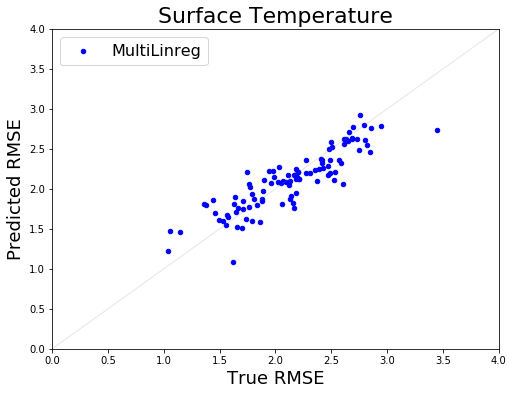

In [27]:
plt.subplots(figsize=(8,20))

#########################
plt.subplot(311)
ax = plt.gca()

title= TITLE 
fluxes_biases.plot(kind='scatter', x='E_PPE', y='E_multilinreg_val', color='blue',  
                     marker="o", ax = ax)
#fluxes_biases.plot(kind='scatter', x='E_PPE', y='E_lasso_val', color='blue', alpha=0.6, 
#                     marker="o", ax = ax)

plt.xlabel('True RMSE', fontsize = 18)#, fontsize=18)
plt.ylabel('Predicted RMSE', fontsize = 18)#, fontsize=18)
plt.legend(['MultiLinreg', 'LASSO'], fontsize = 16)
plt.title(title, fontsize = 22)#, fontsize=22)
plt.ylim(0,4)
plt.xlim(0,4)
ax.plot((0, 4), (0, 4), linewidth=1.0, color='gray', alpha=0.2)

# Enregistrer la figure ...........

plt.savefig("/data/home/globc/peatier/figures/"+variable+"_emulator_skill.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Display the figure 
plt.show()

### Save data 

In [28]:
OSE = fluxes_biases['OSE_multilinreg'].mean()
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/OSE_'+variable+'.npy', OSE)

In [29]:
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/E_p1_'+variable+'.npy', E_p1)

In [30]:
RMSE_val = fluxes_biases['E_multilinreg_val']
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_multilinreg_val_'+variable+'.npy', RMSE_val)

In [31]:
## SAVE 
E_multilinreg_pred = E_multilinreg_pred_df['E_multilinreg_pred'].values
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_multilinreg_pred_'+variable+'.npy', E_multilinreg_pred)

E_PPE = E_PPE_df['E_PPE'].values
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_PPE_'+variable+'.npy', E_PPE)

### [Back to the top](#top)

# <a id="histograms">Figure histograms</a> </li>

In [14]:
E_p1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/E_p1_'+variable+'.npy')
p1_feedbacks = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks_p1.npy')
Fdbck_CFMIP = np.load(file='/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/CMIP6_NetFeedbcks.npy')
Fdbck_PPE = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks.npy")

In [11]:
E_MLR = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_multilinreg_pred_'+variable+'.npy')
Fdbck_MLR = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_prediction_FdbckN.npy")
MLR_df=pd.DataFrame(E_MLR, columns=['E_MLR'])
MLR_df['Fdbck'] = Fdbck_MLR
MLR_df

,E_MLR,Fdbck
0,1.969498,-1.499698
1,2.081600,-1.339351
2,2.055479,-1.323732
3,1.929926,-1.541909
4,2.403458,-1.346961
...,...,...
99995,2.522046,-1.453679
99996,2.338067,-1.410350
99997,1.954258,-1.296397
99998,2.251847,-1.299809


In [12]:
E_MLR_short = []
tmp = []
Fdbck_MLR_short = []
cpt=0

for i in MLR_df['E_MLR']:
    if i <= E_p1:
        E_MLR_short.append(i)
        toto = MLR_df['Fdbck'][cpt]
        Fdbck_MLR_short.append(toto)
        cpt+=1
        
    else:
        tmp.append(i)
        cpt+=1

MLR_short = pd.DataFrame()
MLR_short['Fdbck'] = Fdbck_MLR_short
MLR_short['E_MLR'] = E_MLR_short
MLR_short

,Fdbck,E_MLR
0,-1.499698,1.969498
1,-1.323732,2.055479
2,-1.541909,1.929926
3,-1.181738,2.078129
4,-1.340682,1.647226
...,...,...
44709,-1.161960,1.213864
44710,-1.598518,1.886040
44711,-1.290641,1.936801
44712,-1.296397,1.954258


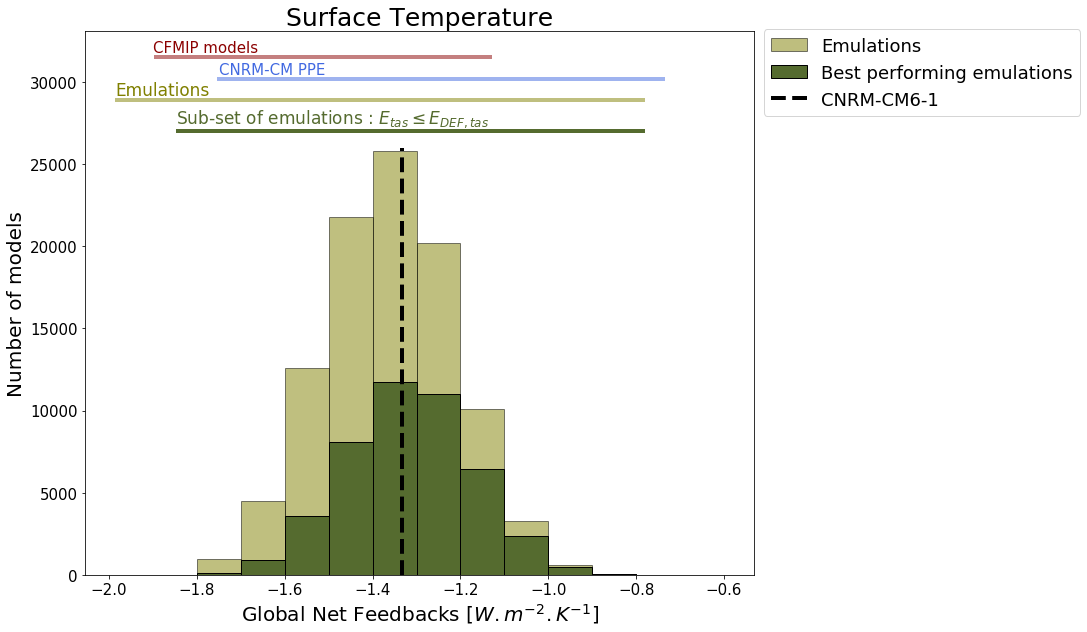

In [16]:
fig, ax = plt.subplots(figsize=(12,10))

Bins = [-1.8,-1.7,-1.6,-1.5,-1.4,-1.3,-1.2,-1.1,-1.0,-0.9,-0.8,-0.7,-0.6]

ax = sns.distplot(Fdbck_MLR, norm_hist=False, bins = Bins, kde = False, 
                  hist_kws={"alpha": 0.5, "color" : 'olive', "edgecolor" : "black"}, 
                  label = 'Emulator', ax=ax)

ax = sns.distplot(MLR_short['Fdbck'], norm_hist=False, bins = Bins, kde = False, 
                 hist_kws={"alpha": 1.0, "color" : 'darkolivegreen', "edgecolor" : "black"}, 
                  label= 'Selected emulations', ax=ax)

#ax = sns.distplot(Fdbck_PPE, norm_hist= False, bins = Bins, kde = False, 
#                  hist_kws={"alpha": 1.0, "color" : 'blue', "edgecolor" : "black"}, 
#                  label = 'PPE', ax=ax)

#ax = sns.distplot(PPE_short_df['Fdbck'], norm_hist= False, bins = Bins, kde = False, 
#                  hist_kws={"alpha": 0.8, "color" : 'navy', "edgecolor" : "black"}, 
#                  label = 'Best PPE members', ax=ax)

plt.vlines(p1_feedbacks,ymin = 0,ymax = 26000,label='CNRM default model', colors='black', linewidth=4.0,
           linestyles='dashed')

plt.hlines(31500.0,xmin = Fdbck_CFMIP.min(),xmax = Fdbck_CFMIP.max(),
           colors='darkred',alpha=0.5, linewidth=4.0, linestyles='solid')
plt.text(-1.9, 31800.0, 'CFMIP models', color = 'darkred', fontsize=15)

plt.hlines(30200.0,xmin = Fdbck_PPE.min(),xmax = Fdbck_PPE.max(),
           colors='royalblue', alpha=0.5, linewidth=4.0, linestyles='solid')
plt.text(-1.75, 30500.0, 'CNRM-CM PPE', color = 'royalblue', fontsize=15)

plt.hlines(28900.0,xmin = Fdbck_MLR.min(),xmax = Fdbck_MLR.max(),
           colors='olive', alpha=0.5,linewidth=4.0, linestyles='solid')
plt.text(Fdbck_MLR.min(), 29200.0, 'Emulations', color = 'olive', fontsize=17)

plt.hlines(27000.0,xmin = MLR_short['Fdbck'].min(),xmax = MLR_short['Fdbck'].max(),
           colors='darkolivegreen', linewidth=4.0, linestyles='solid')
plt.text(MLR_short['Fdbck'].min(), 27500.0, 'Sub-set of emulations : $E_{tas}\leq E_{DEF,tas}$', 
         color = 'darkolivegreen', fontsize=17)

legend=['Emulations', 'Best performing emulations', 'CNRM-CM6-1']
ax.tick_params(axis='both', which='major', labelsize=15)
plt.legend(legend, fontsize=18, bbox_to_anchor=(1.5, 1.02))
plt.title(TITLE, fontsize = 25)
plt.xlabel('Global Net Feedbacks [$W.m^{-2}.K^{-1}$]',fontsize=20)
plt.ylabel('Number of models',fontsize=20)

# Enregistrer la figure ...........

plt.savefig("/data/home/globc/peatier/figures/"+variable+"_threshold_feedbacks.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Display the figure 
plt.show()

In [17]:
E_PPE = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_PPE_'+variable+'.npy')
PPE_df=pd.DataFrame(E_PPE, columns=['E_PPE'])
PPE_df['Fdbck'] = Fdbck_PPE
#PPE_df

In [18]:
E_PPE_short = []
tmp = []
Fdbck_PPE_short = []
cpt=0

for i in PPE_df['E_PPE']:
    if i <= E_p1:
        E_PPE_short.append(i)
        toto = PPE_df['Fdbck'][cpt]
        Fdbck_PPE_short.append(toto)
        cpt+=1
        
    else:
        tmp.append(i)
        cpt+=1

PPE_short = pd.DataFrame()
PPE_short['Fdbck'] = Fdbck_PPE_short
PPE_short['E_PPE'] = E_PPE_short
#PPE_short

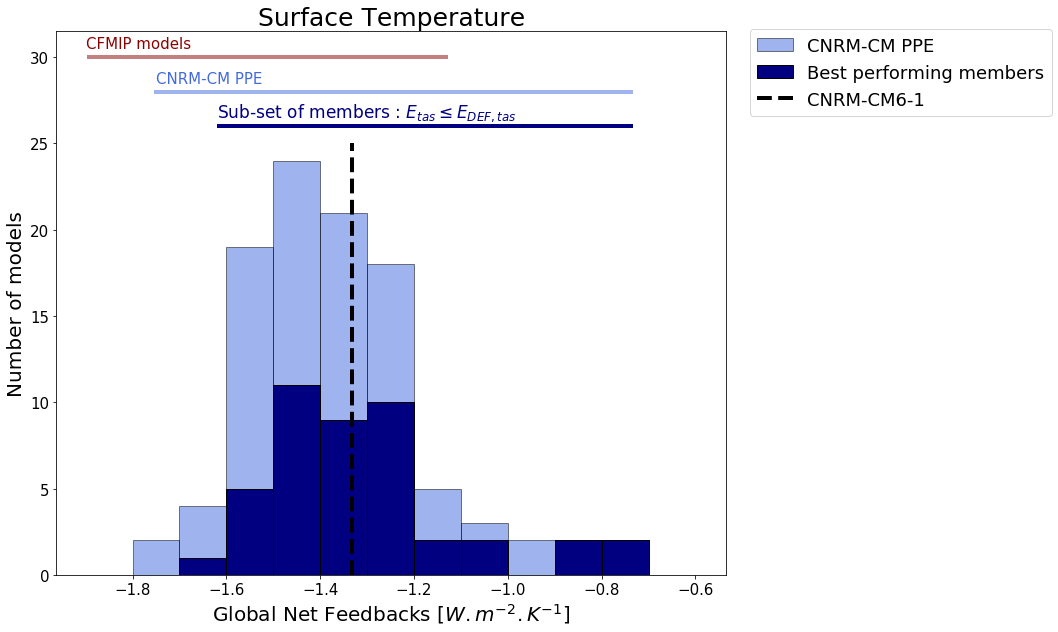

In [19]:
fig, ax = plt.subplots(figsize=(12,10))

Bins = [-1.8,-1.7,-1.6,-1.5,-1.4,-1.3,-1.2,-1.1,-1.0,-0.9,-0.8,-0.7,-0.6]

ax = sns.distplot(Fdbck_PPE, norm_hist=False, bins = Bins, kde = False, 
                  hist_kws={"alpha": 0.5, "color" : 'royalblue', "edgecolor" : "black"}, 
                  label = 'Emulator', ax=ax)

ax = sns.distplot(PPE_short['Fdbck'], norm_hist=False, bins = Bins, kde = False, 
                 hist_kws={"alpha": 1.0, "color" : 'navy', "edgecolor" : "black"}, 
                  label= 'Selected emulations', ax=ax)

#ax = sns.distplot(Fdbck_PPE, norm_hist= False, bins = Bins, kde = False, 
#                  hist_kws={"alpha": 1.0, "color" : 'blue', "edgecolor" : "black"}, 
#                  label = 'PPE', ax=ax)

#ax = sns.distplot(PPE_short_df['Fdbck'], norm_hist= False, bins = Bins, kde = False, 
#                  hist_kws={"alpha": 0.8, "color" : 'navy', "edgecolor" : "black"}, 
#                  label = 'Best PPE members', ax=ax)

plt.vlines(p1_feedback,ymin = 0,ymax = 25,label='CNRM default model', colors='black', linewidth=4.0,
           linestyles='dashed')

plt.hlines(30.0,xmin = Fdbck_CFMIP.min(),xmax = Fdbck_CFMIP.max(),
           colors='darkred',alpha=0.5, linewidth=4.0, linestyles='solid')
plt.text(-1.9, 30.5, 'CFMIP models', color = 'darkred', fontsize=15)

plt.hlines(28.0,xmin = Fdbck_PPE.min(),xmax = Fdbck_PPE.max(),
           colors='royalblue', alpha=0.5, linewidth=4.0, linestyles='solid')
plt.text(-1.75, 28.5, 'CNRM-CM PPE', color = 'royalblue', fontsize=15)

#plt.hlines(28900.0,xmin = Fdbck_MLR.min(),xmax = Fdbck_MLR.max(),
#           colors='olive', alpha=0.5,linewidth=4.0, linestyles='solid')
#plt.text(Fdbck_MLR.min(), 29200.0, 'Emulations', color = 'olive', fontsize=17)

plt.hlines(26.0,xmin = PPE_short['Fdbck'].min(),xmax = PPE_short['Fdbck'].max(),
           colors='navy', linewidth=4.0, linestyles='solid')
plt.text(PPE_short['Fdbck'].min(), 26.5, 'Sub-set of members : $E_{tas}\leq E_{DEF,tas}$', 
         color = 'navy', fontsize=17)

legend=['CNRM-CM PPE', 'Best performing members', 'CNRM-CM6-1']
ax.tick_params(axis='both', which='major', labelsize=15)
plt.legend(legend, fontsize=18, bbox_to_anchor=(1.5, 1.02))
plt.title(TITLE, fontsize = 25)
plt.xlabel('Global Net Feedbacks [$W.m^{-2}.K^{-1}$]',fontsize=20)
plt.ylabel('Number of models',fontsize=20)

# Enregistrer la figure ...........

plt.savefig("/data/home/globc/peatier/figures/PPE_"+variable+"_threshold_feedbacks.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Display the figure 
plt.show()

### [Back to the top](#top)

# <a id="optim">Step 5 - Optimisation</a> </li>

The objective here is to optimize the emulators described above in order to obtain a sub-set of the best parametrizations for each bins of feedback values. In other words, we aim to fine the parametrization which minimizes the error $E_{tot}$ given by the control mean state emulator, while showing a global net feedback value predicted by the feedback emulator within a chosen bin. It is a case of linear minimization with constraint and the optimizer used here comes from the SciPy Python's library and uses sequential least squares programming (SLSQP).

### Functions 

In [32]:
product='BEST'

In [33]:
def Error_emulator(pc1, pc2, pc3, pc4, pc5, variable):
    U_obs = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_obs_'+variable+'_'+product+'.npy')
    E_tmp = (pc1-U_obs[0])**2 + (pc2-U_obs[1])**2 + (pc3-U_obs[2])**2 + (pc4-U_obs[3])**2 + (pc5-U_obs[4])**2
    E = sqrt(E_tmp/5)
    return E

In [34]:
def MultiLinReg_pred(x, EOF_nb, variable) :

    X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
    y = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF"+str(EOF_nb)+"pc_"+variable+".npy")
    param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")
    
    # Let's use the model equation : 

    X_df = pd.DataFrame(data=X)
    regr = linear_model.LinearRegression()
    regr.fit(X, y)
    R = regr.intercept_
    Coeffs = pd.DataFrame([regr.coef_]*30, columns=param_names).iloc[0]

    np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta'+str(EOF_nb)+'.npy', Coeffs)
    np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/R'+str(EOF_nb)+'.npy', R)
    
    tmp = Coeffs.values*x
    y_pred = tmp.sum()+R
    
    return y_pred

In [35]:
# FONCTIONS RMSE

def function_RMSE_emulator_std(x, variable): 
    #mean = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS1000_mean.npy')
    #std = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS1000_std.npy')
    #x_std = (x-mean)/std
    pc1 = MultiLinReg_pred(x, 1, variable)
    pc2 = MultiLinReg_pred(x, 2, variable)
    pc3 = MultiLinReg_pred(x, 3, variable)
    pc4 = MultiLinReg_pred(x, 4, variable)
    pc5 = MultiLinReg_pred(x, 5, variable)
    
    E = Error_emulator(pc1, pc2, pc3, pc4, pc5, variable)
    
    #E = sqrt(tmp_E)
    
    return E

def function_RMSE_emulator(x, variable): 
    MEAN = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_mean.npy')
    STD = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_std.npy')
    
    toto = x - MEAN
    x_std = toto/STD
    
    E = function_RMSE_emulator_std(x_std, variable)
    return E

# FONCTIONS FEEDBACKS

def em_fdb_std(x) :

    X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
    y = np.load(file = "/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks.npy")
    param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")

    # Let's use the model equation : 

    X_df = pd.DataFrame(data=X)
    regr = linear_model.LinearRegression()
    regr.fit(X, y)
    R = regr.intercept_
    Coeffs = pd.DataFrame([regr.coef_]*30, columns=param_names).iloc[0]

    tmp = Coeffs.values*x
    y_pred = tmp.sum()+R
    
    return y_pred

def em_fdb(x) :
    MEAN = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_mean.npy')
    STD = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_std.npy')
    
    toto = x - MEAN
    x_std = toto/STD
    
    y_pred = em_fdb_std(x_std)
    return y_pred

In [36]:
# FONCTION JACOBIAN

def jacobian(x, variable) :
    
    U_obs = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_obs_'+variable+'_'+product+'.npy')
    
    Beta1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta1.npy')
    Beta2 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta2.npy')
    Beta3 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta3.npy')
    Beta4 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta4.npy')
    Beta5 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta5.npy')
    
    R1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/R1.npy')
    R2 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/R2.npy')
    R3 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/R3.npy')
    R4 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/R4.npy')
    R5 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/R5.npy')
    
    C1 = R1 - U_obs[0]
    C2 = R2 - U_obs[1]
    C3 = R3 - U_obs[2]
    C4 = R4 - U_obs[3]
    C5 = R5 - U_obs[4]
    
    MEAN = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_mean.npy')
    STD = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_std.npy')
    
    toto = x - MEAN
    x_std = toto/STD
    
    A = x_std*(Beta1**2 + Beta2**2 + Beta3**2 + Beta4**2 + Beta5**2) + (Beta1*C1 + Beta2*C2 + Beta3*C3 + 
                                                                    Beta4*C4 + Beta5*C5)
    
    tmp = x_std**2*(Beta1**2 + Beta2**2 + Beta3**2 + Beta4**2 + Beta5**2) + 2*x_std*(Beta1*C1 + Beta2*C2 + Beta3*C3 + Beta4*C4 + Beta5*C5) +(C1**2+C2**2+C3**2+C4**2+C5**2)
    B = sqrt(tmp)
    
    D = 1/sqrt(5)
    
    jac = (A/B)*D
    
    return jac


# FONCTIONS CONTRAINTES

def constraint1(x, fdb_low, fdb_hi):
    tmp = (em_fdb(x))
    low = (fdb_low)
    hi = (fdb_hi)
    test = (tmp-fdb_low)
    return test

def constraint2(x, fdb_low, fdb_hi):
    tmp = (em_fdb(x))
    low = (fdb_low)
    hi = (fdb_hi)
    test = (fdb_hi-tmp)
    return test


# FONCTIONS OPTIMISATION

def Optimization(x_best, ind, xlim, variable) :
    
    sol_list=[]
    sol_fdbck=[]
    sol_x=[]
    n = len(x_best)
    cpt=0
    
    for i in range(0, n, 1) :
        x0 = x_best[i]
   
        fdb_low = em_fdb(x0)-ind
        #print('low = '+str(fdb_low))
        fdb_hi = em_fdb(x0)+ind
        #print('hi = '+str(fdb_hi))

        fdb_x0 = em_fdb(x0)
        #print('fdb_x0 = '+str(fdb_x0))
        fun_x0 = function_RMSE_emulator(x0, variable)
        #print('fun_x0 = '+str(fun_x0))

        cons1 = {'type': 'ineq', 'fun' : constraint1, 'args' : [fdb_low, fdb_hi]}
        cons2 = {'type': 'ineq', 'fun' : constraint2, 'args' : [fdb_low, fdb_hi]}
    
        sol = minimize(function_RMSE_emulator,  x0, args=(variable), method='SLSQP', bounds=xlim, constraints=(cons1, cons2), 
                   jac = jacobian, options={'disp': True}, tol = 0.001)    
                        # , 'maxiter' : 250   jac = jacobian,
    

        tmp_fun = function_RMSE_emulator(sol.x, variable)
        tmp_fdbck = em_fdb(sol.x)
        #print('fdb_x = '+str(tmp_fdbck))
    
        sol_list.append(tmp_fun)
        sol_fdbck.append(tmp_fdbck)
        sol_x.append(sol.x)
    
    sol_df = pd.DataFrame()
    sol_df['sol_fun'] = sol_list[:]
    sol_df['Fdbck'] = sol_fdbck[:]
    j=1
    for i in range(0, 30, 1) :
        #print(j)
        sol_df['x'+str(j)+'_smth_0'] = (transpose(sol_x)[i])
        j+=1
    
    return sol_df

In [37]:
def smooth(n, df1, df2):

    for i in range(1,31,1) :
        tmp_x =[df1['x'+str(i)+'_smth_'+str(n-1)][0]]

        for j in range(1,len(df1)-1, 1) : 
            tmp = 0.25*df1['x'+str(i)+'_smth_'+str(n-1)][j-1]+0.5* \
            df1['x'+str(i)+'_smth_'+str(n-1)][j]+0.25*df1['x'+str(i)+'_smth_'+str(n-1)][j+1]
            
            tmp_x.append(tmp)
    
        tmp_x.append(df1['x'+str(i)+'_smth_'+str(n-1)][(len(df1)-1)])
        
        df2['x'+str(i)+'_smth_'+str(n)] = tmp_x

    return df2

### Get the data

In [38]:
E_p1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/E_p1_'+variable+'.npy')
p1_feedbacks = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks_p1.npy')

In [39]:
Fdbck_PPE = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks.npy")
E_PPE = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_PPE_'+variable+'.npy')

E_PPE_df = pd.DataFrame()
E_PPE_df['Fdbck'] = Fdbck_PPE
E_PPE_df['RMSE'] = E_PPE
E_PPE_df

,Fdbck,RMSE
0,-0.825236,1.055966
1,-1.659636,2.821711
2,-1.215000,1.710921
3,-1.321641,2.530649
4,-0.750397,1.557580
...,...,...
97,-1.516367,2.522954
98,-1.584491,2.755906
99,-1.474525,2.746495
100,-1.445422,2.584486


In [40]:
E_multilinreg_pred = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_multilinreg_pred_"+variable+".npy")
Fdbck_multilinreg_pred = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_prediction_FdbckN.npy")


E_multilinreg_pred_df = pd.DataFrame(E_multilinreg_pred)
E_multilinreg_pred_df['E_multilinreg_pred'] = E_multilinreg_pred
E_multilinreg_pred_df['Fdbck_pred'] = Fdbck_multilinreg_pred[0:100000]
E_multilinreg_pred_df = E_multilinreg_pred_df.drop([0], axis=1)
E_multilinreg_pred_df

,E_multilinreg_pred,Fdbck_pred
0,1.969498,-1.499698
1,2.081600,-1.339351
2,2.055479,-1.323732
3,1.929926,-1.541909
4,2.403458,-1.346961
...,...,...
99995,2.522046,-1.453679
99996,2.338067,-1.410350
99997,1.954258,-1.296397
99998,2.251847,-1.299809


### Initial guess for Optimization 1

In [41]:
E_multilinreg_pred_df['Fdbck_pred_round'] = E_multilinreg_pred_df['Fdbck_pred'].round(decimals=2)
E_multilinreg_pred_df = E_multilinreg_pred_df.set_index('Fdbck_pred_round')
E_multilinreg_pred_df['members'] = range(0,100000,1) 
#E_multilinreg_pred_df        

In [42]:
new_df=pd.DataFrame()
new_df['E_multilinreg_pred_best'] = E_multilinreg_pred_df['E_multilinreg_pred'].groupby('Fdbck_pred_round').min()
new_df = new_df.reset_index()
#new_df

In [43]:
list_RMSE = new_df['E_multilinreg_pred_best']
n = len(list_RMSE)

tmp_fdbck = []
tmp_member = []
tmp_pc1 = []
cpt=0
ind=0
cpt_other=0
for i in E_multilinreg_pred_df['E_multilinreg_pred'] :
    for j in list_RMSE :
        if i==j:
            #print(cpt)
            tmp_fdbck.append(E_multilinreg_pred_df['Fdbck_pred'].iloc[cpt])
            tmp_member.append(E_multilinreg_pred_df['members'].iloc[cpt])
        else :
            cpt_other+=1
    cpt+=1

fdbck = [k for k in tmp_fdbck if k != 0]
members = [l for l in tmp_member if l != 0]
pc1 = [l for l in tmp_pc1 if l != 0]

df = pd.DataFrame()
df['fdbck'] = fdbck
df['members'] = members
df_sort = df.sort_values(by=['fdbck']).reset_index().drop('index', axis=1)
df_sort

new_df['Fdbck_pred'] = df_sort['fdbck']
new_df['members'] = df_sort['members']
#new_df

### Optimization 1 

In [44]:
LHS = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_param.npy")

x_best = []
for i in new_df['members']:
    #print(i)
    x_best.append(LHS[i])

x_best=np.array(x_best)
#x_best

In [45]:
param = pd.read_csv("/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/csv/param.csv",sep=' ', header=None)
param_int = param.set_index(0).transpose()
param_names = param[0]

N=len(param_names)
xlimits=[[1,1]]*N
i=0
while i<N:
    name = param_names[i]
    xmin = param_int[name].iloc[0]
    xmax = param_int[name].iloc[1]
    if xmin<xmax:
        limit = [xmin, xmax]
    else:
        limit = [xmax, xmin]
    xlimits[i] = limit
    i+=1
    
xlim = np.array(xlimits)
#xlim

In [46]:
sol_df = Optimization(x_best, 0.0001, xlim, variable)
#sol_df

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.6747850221505058
            Iterations: 3
            Function evaluations: 14
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.27435162942395
            Iterations: 9
            Function evaluations: 22
            Gradient evaluations: 9
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.1602292485979249
            Iterations: 9
            Function evaluations: 22
            Gradient evaluations: 9
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.0383552866006402
            Iterations: 9
            Function evaluations: 20
            Gradient evaluations: 9
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.4136856886010474
            Iterations: 8
            Function evaluatio

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.9844708507844188
            Iterations: 3
            Function evaluations: 15
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.8704172315541324
            Iterations: 4
            Function evaluations: 19
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.8014512510218934
            Iterations: 4
            Function evaluations: 18
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.9893201672478088
            Iterations: 4
            Function evaluations: 21
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.9168491613335746
            Iterations: 4
            Function evaluat

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.3523295799565562
            Iterations: 5
            Function evaluations: 12
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.2696916344830235
            Iterations: 3
            Function evaluations: 15
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.38913363888318175
            Iterations: 5
            Function evaluations: 20
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.26337009413116147
            Iterations: 7
            Function evaluations: 22
            Gradient evaluations: 7
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.7069432050704022
            Iterations: 2
            Function evalu

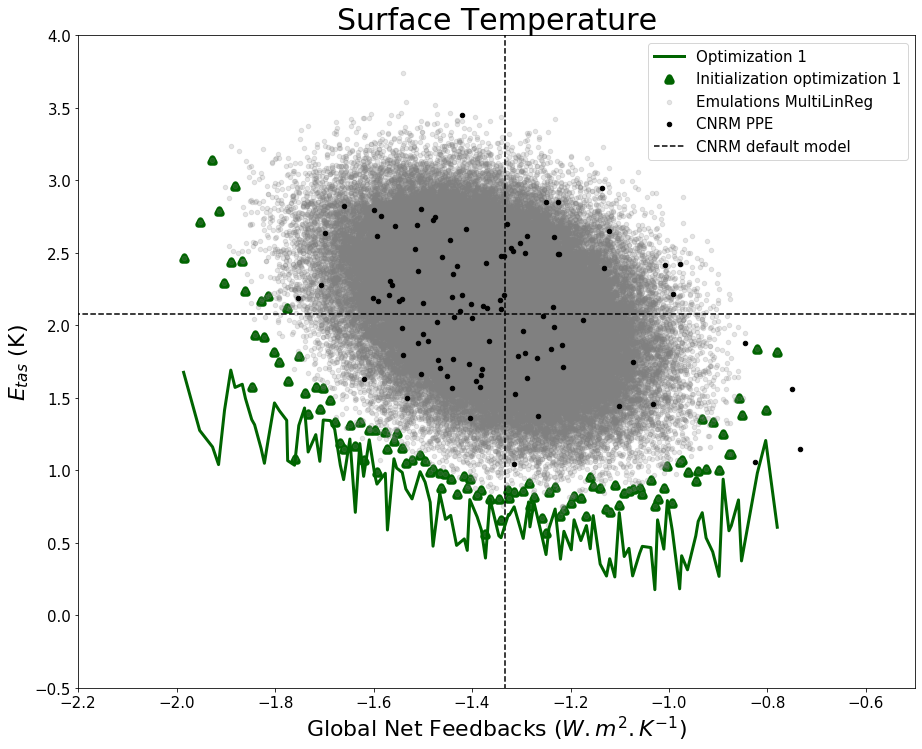

In [47]:
ax = plt.gca()

#plt.plot(Fdbck_MRI, E_MRI, color='orange', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_CAN, E_CAN, color='navy', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_MIROC, E_MIROC, color='darkred', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_HadGEM3, E_HadGEM3, color='darkgray', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_IPSL, E_IPSL, color='pink', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_BCC, E_BCC, color='blue', marker='^', linewidth=0, markersize=12)

new_df.plot(kind='scatter', x='Fdbck_pred', y='E_multilinreg_pred_best', color = 'darkgreen', 
         marker = '^', linewidth=6,  ax = ax)

sol_df.plot(kind='line', x='Fdbck', y='sol_fun', color = 'darkgreen', 
         linewidth=3, ax = ax)

E_multilinreg_pred_df.plot(kind='scatter', x='Fdbck_pred', y='E_multilinreg_pred', 
                           color='gray', alpha=0.2, figsize=(15, 12), marker='o', ax = ax)

E_PPE_df.plot(kind='scatter', x='Fdbck', y='RMSE', color='black', figsize=(15, 12), 
                     marker="o", ax = ax)



plt.hlines(E_p1,xmin = -4.0,xmax = 2.0,label='default simulation', colors='black', 
           linestyles='dashed')
plt.vlines(p1_feedbacks,ymin = -10,ymax = 25,label='default simulation', colors='black', 
           linestyles='dashed')


#'MRI model', 'CAN model', 'MIROC model', 'HadGEM3 model', 'IPSL model','BCC model', 
legend = ['Optimization 1', 'Initialization optimization 1', 'Emulations MultiLinReg', 'CNRM PPE', 'CNRM default model']

plt.xlabel('Global Net Feedbacks ($W.m^2.K^{-1}$)', fontsize=22)
plt.ylabel(ylabel, fontsize=22)
plt.legend(legend, fontsize=15)
plt.title(TITLE, fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylim(-0.5,4)
plt.xlim(-2.2,-0.5)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/RMSE_"+variable+"_PPE_optim1.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

### Initial guess for Optimization 2 (param. moothing)

In [48]:
new_sol_df = pd.DataFrame()
new_sol_df['Fdbck'] = sol_df['Fdbck']

new_sol_df = smooth(1, sol_df, new_sol_df)

n = 151
for i in range(2,n,1) :
    new_sol_df = smooth(i, new_sol_df, new_sol_df)
    
new_sol_df

,Fdbck,x1_smth_1,x2_smth_1,x3_smth_1,x4_smth_1,x5_smth_1,x6_smth_1,x7_smth_1,x8_smth_1,x9_smth_1,...,x21_smth_150,x22_smth_150,x23_smth_150,x24_smth_150,x25_smth_150,x26_smth_150,x27_smth_150,x28_smth_150,x29_smth_150,x30_smth_150
0,-1.985856,0.280000,0.895829,2.472964,29.618279,-0.010000,7.918879e+00,2.950507,0.000500,0.001000,...,-2.477096,-25.249633,0.065449,13.963141,0.00001,0.796676,0.500000,0.522475,0.500000,6.143285
1,-1.953241,0.264607,0.678017,2.868241,20.925873,-0.010000,1.979720e+00,2.237460,0.000500,0.001000,...,-2.534650,-25.930680,0.064817,13.734842,0.00001,0.794863,0.506200,0.543244,0.501522,6.034710
2,-1.927100,0.272304,0.539534,3.000000,19.971278,-0.010000,3.429278e-13,0.836179,0.000500,0.001000,...,-2.591552,-26.601298,0.064167,13.506538,0.00001,0.793035,0.512400,0.563828,0.503051,5.928658
3,-1.914873,0.280000,0.543982,2.839880,20.712566,-0.010000,2.357018e-13,1.422377,0.000500,0.001000,...,-2.647155,-27.251537,0.063480,13.278317,0.00001,0.791178,0.518603,0.584045,0.504597,5.827536
4,-1.902738,0.280000,0.607912,2.464920,21.075010,-0.010000,9.266859e-01,2.866082,0.000500,0.001000,...,-2.700827,-27.872369,0.062741,13.050431,0.00001,0.789276,0.524811,0.603717,0.506165,5.733532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,-0.858878,0.280000,2.093439,1.815742,14.262882,-0.088168,1.598596e+00,4.531152,0.001461,0.000259,...,-2.540798,-44.069135,0.010011,8.037143,0.00010,0.557147,0.523072,0.942023,0.809212,6.919509
109,-0.852749,0.280000,2.285341,1.463418,16.367042,-0.098967,8.807803e-01,6.162176,0.000980,0.000216,...,-2.531552,-44.868579,0.010008,8.358470,0.00010,0.549802,0.518479,0.951876,0.826567,7.129589
110,-0.820549,0.280000,2.384961,1.411050,17.664717,-0.135079,1.912952e-01,5.082859,0.000500,0.000091,...,-2.522751,-45.692021,0.010005,8.701080,0.00010,0.542199,0.513578,0.961963,0.844575,7.350112
111,-0.803575,0.280000,2.475961,1.472710,22.319795,-0.197315,4.705814e-01,4.637469,0.000500,0.000050,...,-2.514275,-46.532037,0.010002,9.058406,0.00010,0.534418,0.508463,0.972210,0.863034,7.577815


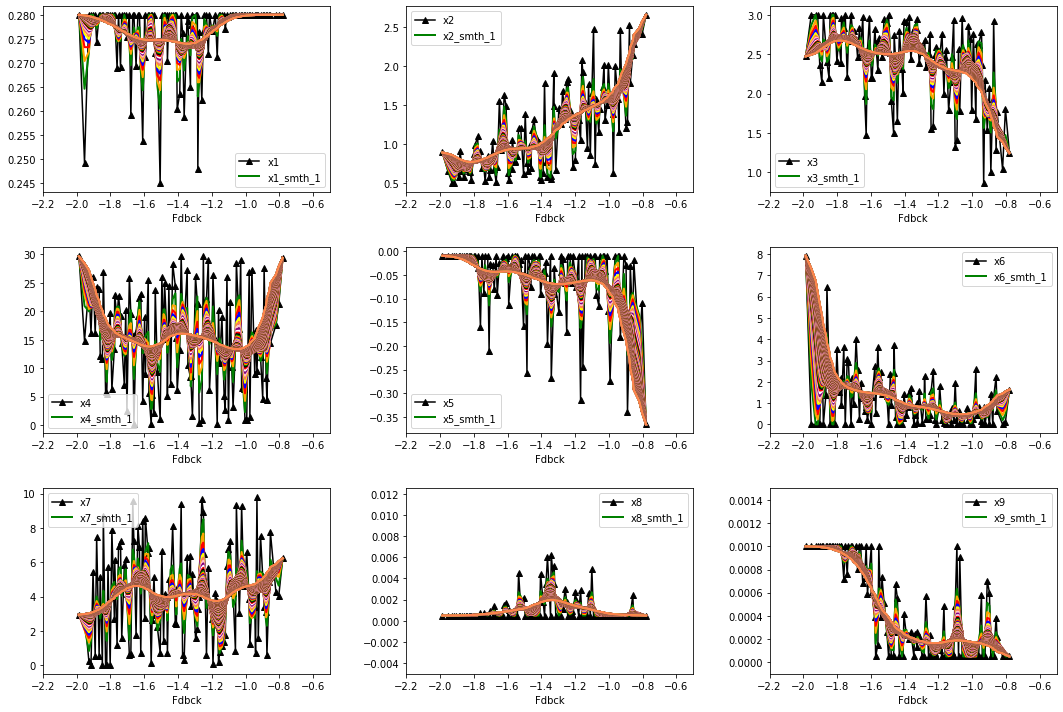

In [49]:
# SETTINGS ------------------

n = 150

colors = ['black', 'green', 'orange', 'red', 'blue', 'yellow', 'coral', 'pink', 'purple', 'white','red']*100

# Plot of lines from different dataframes
plt.subplots(figsize=(15,10)) 

plt.subplot(331)

ax1 = plt.gca()
title = 'parameter 1'

sol_df.plot(kind='line', x='Fdbck', y='x1_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax1)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x1_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax1)

plt.xlim(-2.2,-0.5)
plt.legend(['x1', 'x1_smth_1'])
plt.subplot(332)

ax2 = plt.gca()
title = 'parameter 2'

sol_df.plot(kind='line', x='Fdbck', y='x2_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax2)
for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x2_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax2)

plt.xlim(-2.2,-0.5)
plt.legend(['x2', 'x2_smth_1'])
plt.subplot(333)

ax3 = plt.gca()
title = 'parameter 3'

sol_df.plot(kind='line', x='Fdbck', y='x3_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax3)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x3_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax3)

plt.xlim(-2.2,-0.5)
plt.legend(['x3', 'x3_smth_1'])
plt.subplot(334)

ax4 = plt.gca()
title = 'parameter 4'

sol_df.plot(kind='line', x='Fdbck', y='x4_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax4)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x4_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax4)

plt.xlim(-2.2,-0.5)
plt.legend(['x4', 'x4_smth_1'])
plt.subplot(335)

ax5 = plt.gca()
title = 'parameter 5'

sol_df.plot(kind='line', x='Fdbck', y='x5_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax5)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x5_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax5)

plt.xlim(-2.2,-0.5)
plt.legend(['x5', 'x5_smth_1'])
plt.subplot(336)

ax6 = plt.gca()
title = 'parameter 6'

sol_df.plot(kind='line', x='Fdbck', y='x6_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax6)

for i in range(1,n,1) : 
    new_sol_df.plot(kind='line', x='Fdbck', y='x6_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax6)
    
plt.xlim(-2.2,-0.5)
plt.legend(['x6', 'x6_smth_1'])
plt.subplot(337)

ax7 = plt.gca()
title = 'parameter 7'

sol_df.plot(kind='line', x='Fdbck', y='x7_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax7)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x7_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax7)

plt.xlim(-2.2,-0.5)
plt.legend(['x7', 'x7_smth_1'])
plt.subplot(338)

ax8 = plt.gca()
title = 'parameter 8'

sol_df.plot(kind='line', x='Fdbck', y='x8_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax8)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x8_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax8)

plt.ylim(-0.005,0.0125)
plt.xlim(-2.2,-0.5)
plt.legend(['x8', 'x8_smth_1'])
plt.subplot(339)

ax9 = plt.gca()
title = 'parameter 9'

sol_df.plot(kind='line', x='Fdbck', y='x9_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax9)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x9_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax9)

plt.ylim(-0.0001,0.0015)
plt.xlim(-2.2,-0.5)
plt.legend(['x9', 'x9_smth_1'])

#Ajustement des subplots
plt.tight_layout()
plt.subplots_adjust(hspace = 0.30)

# Enregistrer la figure .....................

#plt.savefig("/data/home/globc/peatier/figures/longPPE_N_tas_future4K.png", 
#        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

### Optimization 2

In [50]:
x_best_2 = pd.DataFrame()
for k in range(1,31,1) : 
    x_best_2['x'+str(k)+'_best'] = new_sol_df['x'+str(k)+'_smth_150']

x_best_2 = x_best_2.to_numpy()
x_best_2

array([[0.28      , 0.89582859, 2.47296381, ..., 0.52247485, 0.5       ,
        6.14328479],
       [0.27987009, 0.8793216 , 2.49309745, ..., 0.54324403, 0.50152169,
        6.03470981],
       [0.27974052, 0.86317441, 2.51301577, ..., 0.56382806, 0.50305147,
        5.92865772],
       ...,
       [0.2799989 , 2.49008833, 1.38472801, ..., 0.96196304, 0.84457501,
        7.35011228],
       [0.27999949, 2.57493622, 1.31525648, ..., 0.97221001, 0.86303353,
        7.57781516],
       [0.28      , 2.66055884, 1.24542094, ..., 0.98253866, 0.88172236,
        7.80917525]])

In [51]:
init_df = pd.DataFrame()
init_df['Fdbck'] = sol_df['Fdbck']

tmp_fun = []
for i in x_best_2 :
    tmp = function_RMSE_emulator(i, variable)
    tmp_fun.append(tmp)
init_df['RMSE'] = tmp_fun
init_df

,Fdbck,RMSE
0,-1.985856,1.674785
1,-1.953241,1.627004
2,-1.927100,1.581403
3,-1.914873,1.538437
4,-1.902738,1.498415
...,...,...
108,-0.858878,0.423394
109,-0.852749,0.462864
110,-0.820549,0.507039
111,-0.803575,0.555130


In [52]:
sol_df_2 = Optimization(x_best_2, 0.0001, xlim, variable)
#sol_df_2

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.1373291612914416
            Iterations: 10
            Function evaluations: 32
            Gradient evaluations: 10
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.6196591963105655
            Iterations: 2
            Function evaluations: 13
            Gradient evaluations: 2
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.5741787341688964
            Iterations: 2
            Function evaluations: 13
            Gradient evaluations: 2
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.5316837690594134
            Iterations: 2
            Function evaluations: 13
            Gradient evaluations: 2
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.4964283004327064
            Iterations: 2
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.7582129500499106
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.7401869795295561
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.7221912432338023
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.7042348233027794
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.6863637426830663
            Iterations: 1
            Function evaluat

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.31696024358245084
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.3088523742506201
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.3017323803936432
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.2956899887181208
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.2907712519755318
            Iterations: 1
            Function evalua

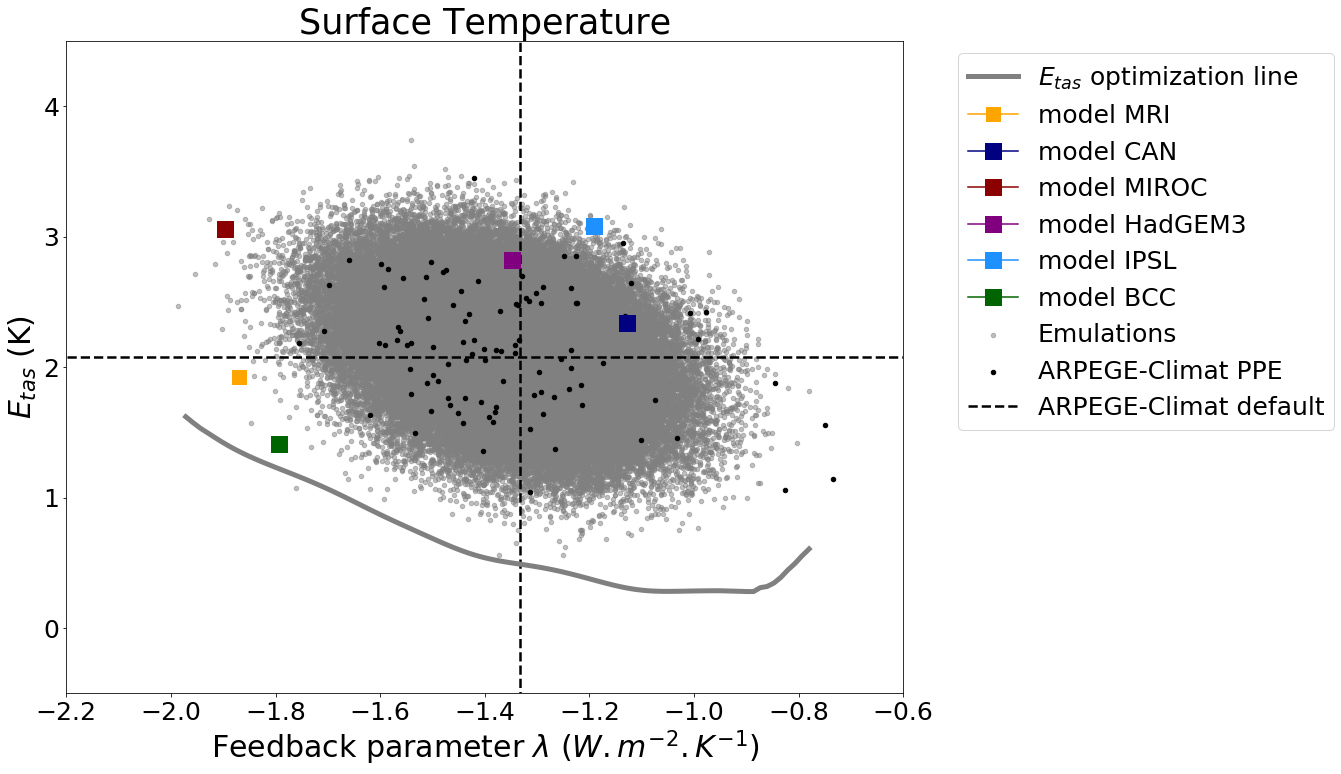

In [53]:
colors = ['coral','blue','orange','black','green','red','purple','yellow','cornflowerblue']
cpt=0

ax = plt.gca()

#new_df.plot(kind='scatter', x='Fdbck_pred', y='E_multilinreg_pred_best', color = 'darkgreen', alpha=0.3,
#         marker = '^', linewidth=6,  ax = ax)

#init_df.plot(kind='scatter', x='Fdbck', y='RMSE', color = 'darkgreen', alpha=1,
#         marker = '^', linewidth=6,  ax = ax)

#sol_df.plot(kind='line', x='Fdbck', y='sol_fun', color = 'darkgreen', alpha=0.3,
#         linewidth=3, ax = ax)

sol_df_2[1:].plot(kind='line', x='Fdbck', y='sol_fun', color = 'gray', alpha=1, linewidth=5, ax = ax)

E_multilinreg_pred_df.plot(kind='scatter', x='Fdbck_pred', y='E_multilinreg_pred', 
                           color='gray', alpha=0.5, figsize=(15, 12), marker='o', ax = ax)

E_PPE_df.plot(kind='scatter', x='Fdbck', y='RMSE', color='black', figsize=(15, 12), alpha=1.0,
                     marker="o", ax = ax)

plt.hlines(E_p1,xmin = -10.0,xmax = 25.0,label='default simulation', colors='black', 
           linestyles='dashed', linewidth=2.5)
plt.vlines(p1_feedbacks,ymin = -10,ymax = 25,label='default simulation', colors='black', 
           linestyles='dashed', linewidth=2.5)

plt.plot(Fdbck_MRI, E_MRI, color='orange', marker='s', markeredgewidth=0, markersize=15, zorder=20)
plt.plot(Fdbck_CAN, E_CAN, color='navy', marker='s', markeredgewidth=2, markersize=15, zorder=30)
plt.plot(Fdbck_MIROC, E_MIROC, color='darkred', marker='s', markeredgewidth=2, markersize=15, zorder=20)
plt.plot(Fdbck_HadGEM3, E_HadGEM3, color='purple', marker='s', markeredgewidth=2, markersize=15, zorder=20)
plt.plot(Fdbck_IPSL, E_IPSL, color='dodgerblue', marker='s', markeredgewidth=2, markersize=15, zorder=20)
plt.plot(Fdbck_BCC, E_BCC, color='darkgreen', marker='s', markeredgewidth=2, markersize=15, zorder=20)


legend = [ '$E_{tas}$ optimization line', 'model MRI','model CAN','model MIROC','model HadGEM3','model IPSL', 'model BCC', 
          'Emulations','ARPEGE-Climat PPE', 'ARPEGE-Climat default']
plt.xlabel('Feedback parameter $\lambda$ ($W.m^{-2}.K^{-1}$)', fontsize=30)
plt.ylabel(ylabel, fontsize=30)
plt.legend(legend, fontsize=25, bbox_to_anchor=(1.05, 1))

plt.title(TITLE, fontsize=35)
ax.tick_params(axis='both', which='major', labelsize=25)
plt.ylim(-0.5,4.5)
plt.xlim(-2.2,-0.6)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/RMSE_"+variable+"_PPE_optim2.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

### Save data

In [54]:
RMSE_optim2 = sol_df_2['sol_fun']
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_optim2_'+variable+'.npy', RMSE_optim2)

Fdbck_optim2 = sol_df_2['Fdbck']
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Fdbck_optim2_'+variable+'.npy', Fdbck_optim2)

### [Back to the top](#top)

# <a id="selection">Step 6 - Optimal subset of parameters</a> </li>

## Projection of sub-set on EOF basis

### Settings 

In [20]:
ENSEMBLE = 'ENSEMBLE4_selection/'
path_PPE_short = '/data/scratch/globc/peatier/CNRM-CM6-1_PPE/'
product = 'BEST'
ylabel = '$E_{tas}$ (K)'

In [21]:
nb_p_list_LHS500 = ['p810', 'p812', 'p813', 'p814','p815', 'p816', 'p817']
len(nb_p_list_LHS500)

7

### Functions

In [22]:
def Error_emulator(pc1, pc2, pc3, pc4, pc5, variable):
    U_obs = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_obs_'+variable+'_'+product+'.npy')
    E_tmp = (pc1-U_obs[0])**2 + (pc2-U_obs[1])**2 + (pc3-U_obs[2])**2 + (pc4-U_obs[3])**2 + (pc5-U_obs[4])**2
    E = sqrt(E_tmp/5)
    return E

In [23]:
def MultiLinReg_pred(x, EOF_nb, variable) :

    X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
    y = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF"+str(EOF_nb)+"pc_"+variable+".npy")
    param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")
    
    # Let's use the model equation : 

    X_df = pd.DataFrame(data=X)
    regr = linear_model.LinearRegression()
    regr.fit(X, y)
    R = regr.intercept_
    Coeffs = pd.DataFrame([regr.coef_]*30, columns=param_names).iloc[0]

    np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta'+str(EOF_nb)+'.npy', Coeffs)
    np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/R'+str(EOF_nb)+'.npy', R)
    
    tmp = Coeffs.values*x
    y_pred = tmp.sum()+R
    
    return y_pred


# FONCTIONS RMSE

def function_RMSE_emulator_std(x, variable): 
    #mean = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS1000_mean.npy')
    #std = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS1000_std.npy')
    #x_std = (x-mean)/std
    pc1 = MultiLinReg_pred(x, 1, variable)
    pc2 = MultiLinReg_pred(x, 2, variable)
    pc3 = MultiLinReg_pred(x, 3, variable)
    pc4 = MultiLinReg_pred(x, 4, variable)
    pc5 = MultiLinReg_pred(x, 5, variable)
    
    E = Error_emulator(pc1, pc2, pc3, pc4, pc5, variable)
    
    #E = sqrt(tmp_E)
    
    return E

def function_RMSE_emulator(x, variable): 
    MEAN = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_mean.npy')
    STD = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_std.npy')
    
    toto = x - MEAN
    x_std = toto/STD
    
    E = function_RMSE_emulator_std(x_std, variable)
    return E

### EOF, tas_mean and PCs

In [24]:
Mean =  pd.read_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_'+variable+'_mean.npy').to_xarray().to_array()
Mean = Mean[0,:,:].rename({'variable':'mode'})
#Mean

In [25]:
eof1 = pd.read_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOFmap1_'+variable+'.npy').to_xarray().to_array()
eof2 = pd.read_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOFmap2_'+variable+'.npy').to_xarray().to_array()
eof3 = pd.read_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOFmap3_'+variable+'.npy').to_xarray().to_array()
eof4 = pd.read_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOFmap4_'+variable+'.npy').to_xarray().to_array()
eof5 = pd.read_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOFmap5_'+variable+'.npy').to_xarray().to_array()

eof1 = eof1[0,:,:].rename({'variable':'mode'})
eof2 = eof2[0,:,:].rename({'variable':'mode'})
eof3 = eof3[0,:,:].rename({'variable':'mode'})
eof4 = eof4[0,:,:].rename({'variable':'mode'})
eof5 = eof5[0,:,:].rename({'variable':'mode'})

eofs = [eof1,eof2,eof3,eof4,eof5]

In [26]:
eofs_combined = xr.combine_nested(eofs, concat_dim='eofs')
#eofs_combined

In [27]:
pc1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF1pc_'+variable+'.npy')
pc2 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF2pc_'+variable+'.npy')
pc3 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF3pc_'+variable+'.npy')
pc4 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF4pc_'+variable+'.npy')
pc5 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF5pc_'+variable+'.npy')

PC_df = pd.DataFrame(pc1)
PC_df['pc1'] = pc1
PC_df['pc2'] = pc2
PC_df['pc3'] = pc3
PC_df['pc4'] = pc4
PC_df['pc5'] = pc5
PC_df = PC_df.drop(labels = 0, axis=1)
#PC_df

PC_df

,pc1,pc2,pc3,pc4,pc5
0,-1.037732,-1.772081,0.099338,0.586538,1.931625
1,0.500078,0.633004,-0.643880,-0.070027,-1.880748
2,1.538930,-0.967792,0.192939,-0.498432,1.072165
3,0.524819,-1.622346,-0.740827,-1.025524,-1.134253
4,0.683105,0.110459,0.257606,0.863912,0.866224
...,...,...,...,...,...
97,1.117563,-0.113455,-1.874182,-1.371712,-0.314159
98,-0.847133,2.220053,-2.073222,-0.161396,-0.380162
99,-0.200386,1.630405,-0.603055,-1.124290,-0.793313
100,1.692824,0.389283,-1.014095,-1.902700,0.029599


### Get the subset data

In [28]:
E_p1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/E_p1_'+variable+'.npy')
p1_feedbacks = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks_p1.npy')

In [29]:
path_PPE = path_PPE_short+ENSEMBLE
amip ={} 
    
# Load data :
for i in nb_p_list_LHS500 :
    path=path_PPE+'CNRM-CM6-1_amip_PPE_ENSEMBLE4_selection/CNRM-CM6-1_amip_r1i1'+i+'f2/'
    filename = '*_CNRM-CM6-1_amip_r1i1'+i+'f2*.nc'
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    df_tmp = file[variable].to_dataframe().drop('height',axis=1)
    df_tmp_2 = df_tmp.reset_index(level=['time', 'lat', 'lon'])
    df_tmp_2['month']=pd.DatetimeIndex(df_tmp_2['time']).month
    df_tmp_3 = df_tmp_2.groupby(['month', 'lat', 'lon']).mean()
    amip[i] = df_tmp_3.groupby(['lat','lon']).mean().to_xarray()
    #amip[i]['SW'] = amip[i]['rsdt'] - amip[i]['rsut']
    #amip[i]['pr'] = amip[i]['pr'] * 86400

print(amip[i][variable])

<xarray.DataArray 'tas' (lat: 128, lon: 256)>
array([[224.67926, 224.67926, 224.67926, ..., 224.67926, 224.67926,
        224.67926],
       [227.7995 , 227.7995 , 227.7995 , ..., 227.7995 , 227.7995 ,
        227.7995 ],
       [227.40262, 227.40262, 227.40262, ..., 227.82886, 227.40262,
        227.40262],
       ...,
       [253.14355, 253.14355, 253.14355, ..., 253.00513, 253.14355,
        253.14355],
       [251.84903, 251.84903, 251.84903, ..., 251.84903, 251.84903,
        251.84903],
       [250.53377, 250.53377, 250.53377, ..., 250.53377, 250.53377,
        250.53377]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6


### Compute Anomaly

In [30]:
X = {}
for i in nb_p_list_LHS500 :
    tmp = amip[i][variable].data - Mean.data
    X[i] = xr.DataArray(tmp, dims=['lat', 'lon'])
X[i]

<xarray.DataArray (lat: 128, lon: 256)>
array([[-0.7850647 , -0.7850647 , -0.7850647 , ..., -0.7850647 ,
        -0.7850647 , -0.7850647 ],
       [-0.37528992, -0.37528992, -0.37528992, ..., -0.37528992,
        -0.37528992, -0.37528992],
       [-0.6906738 , -0.6906738 , -0.6906738 , ..., -0.657547  ,
        -0.6906738 , -0.6906738 ],
       ...,
       [-3.1696777 , -3.1696777 , -3.1696777 , ..., -3.2519836 ,
        -3.1696777 , -3.1696777 ],
       [-3.6611023 , -3.6611023 , -3.6611023 , ..., -3.6611023 ,
        -3.6611023 , -3.6611023 ],
       [-3.705536  , -3.705536  , -3.705536  , ..., -3.705536  ,
        -3.705536  , -3.705536  ]], dtype=float32)
Dimensions without coordinates: lat, lon

### Trouver U_PPE

In [31]:
eofs_inv = np.linalg.pinv(eofs_combined.transpose())
#eofs_inv = xr.DataArray(eofs_inv, dims=['eofs','lon','lat'])
shape(eofs_inv)

(256, 5, 128)

In [32]:
U={}
for i in nb_p_list_LHS500 :
    U[i] = np.dot(eofs_inv,X[i])#.transpose('lon','lat')

U

{'p810': array([[[ 0.57293427,  0.6084046 ,  0.62653035, ...,  0.56578034,
           0.5845298 ,  0.5674777 ],
         [ 0.57497543,  0.5968273 ,  0.6582301 , ...,  0.5014498 ,
           0.61466986,  0.58376455],
         [ 1.9732208 ,  1.8390776 ,  1.7780141 , ...,  2.1259499 ,
           2.0600467 ,  2.0280623 ],
         [-2.005266  , -1.7742465 , -1.8414378 , ..., -2.2050536 ,
          -2.2543292 , -2.214374  ],
         [-0.15298209, -0.32253057, -0.3222614 , ...,  0.31622326,
           0.10967637, -0.08420324]],
 
        [[ 0.5776356 ,  0.6097384 ,  0.6272518 , ...,  0.5565085 ,
           0.5731589 ,  0.57101744],
         [ 0.6009773 ,  0.597647  ,  0.6453507 , ...,  0.5200866 ,
           0.6402592 ,  0.6247631 ],
         [ 1.9220685 ,  1.8043538 ,  1.7485907 , ...,  2.1476204 ,
           2.0775933 ,  1.9788929 ],
         [-1.8177974 , -1.6476241 , -1.7374712 , ..., -2.157236  ,
          -2.1693237 , -2.0022147 ],
         [-0.18390466, -0.39980495, -0.42330423, ...,

In [33]:
U_avg={}
for i in nb_p_list_LHS500 :
    U[i] = xr.DataArray(U[i], dims=['lon','eofs','lon2'])
    U_avg[i] = U[i][0,:,0].transpose()

U_avg

{'p810': <xarray.DataArray (eofs: 5)>
 array([ 0.57293427,  0.57497543,  1.9732208 , -2.005266  , -0.15298209],
       dtype=float32)
 Dimensions without coordinates: eofs, 'p812': <xarray.DataArray (eofs: 5)>
 array([ 0.6821011 , -1.2283556 ,  0.89717203,  0.5717874 ,  2.6210186 ],
       dtype=float32)
 Dimensions without coordinates: eofs, 'p813': <xarray.DataArray (eofs: 5)>
 array([ 0.5423005 , -1.640776  ,  1.1919888 ,  0.42733228,  4.0932264 ],
       dtype=float32)
 Dimensions without coordinates: eofs, 'p814': <xarray.DataArray (eofs: 5)>
 array([ 0.1216846, -1.6245865,  0.308921 ,  1.2732401,  3.4068518],
       dtype=float32)
 Dimensions without coordinates: eofs, 'p815': <xarray.DataArray (eofs: 5)>
 array([ 0.3294735 , -0.6668262 , -0.08333512,  1.3133837 ,  1.2312343 ],
       dtype=float32)
 Dimensions without coordinates: eofs, 'p816': <xarray.DataArray (eofs: 5)>
 array([ 0.38478947, -0.8811011 , -0.79679793,  2.100965  ,  0.16142665],
       dtype=float32)
 Dimensions

In [34]:
#Save the U_avg 
for i in nb_p_list_LHS500 :
    np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE4_selection/files/npy/U_'+i+'_'+variable+'.npy', U_avg[i])

## Error estimate in ARPEGE-Climat

In [35]:
E_df_selection=[]
for i in nb_p_list_LHS500 :
    U = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE4_selection/files/npy/U_'+i+'_'+variable+'.npy')
    pc1 = U[0]
    pc2 = U[1]
    pc3 = U[2]
    pc4 = U[3]
    pc5 = U[4]
    E = Error_emulator(pc1, pc2, pc3, pc4, pc5, variable)
    E_df_selection.append(E)

E_df_selection

[2.7166715832228876,
 0.8930138007642927,
 0.8296358365233248,
 0.32092738853862657,
 1.2203496936814204,
 1.7136119427696155,
 1.0490988083642743]

In [36]:
Fdbck_selection = np.load('/data/home/globc/peatier/CNRMppe/PPE/'+ENSEMBLE+'files/npy/Net_feedbacks.npy')
Fdbck_selection

array([-1.78161049, -1.66763945, -1.55991312, -1.43519366, -1.05908251,
       -0.70464752, -0.64373523])

## Error estimate with emulator

In [55]:
file = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_optim2_select.npy')
df_select = pd.DataFrame(file).drop([1, 8])
df_select

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,1.373122,-1.985856,0.146328,0.780122,1.444682,29.576978,-0.010000,7.191997,2.930061,0.000500,...,-2.442926,-25.204834,0.080632,13.397143,0.000010,0.786024,0.500000,0.644484,0.500000,5.629949
2,1.048298,-1.639310,0.172008,0.998078,1.836255,14.147628,-0.067522,2.431632,4.685189,0.003715,...,-2.866823,-31.997047,0.050568,10.558879,0.000042,0.845763,0.700214,0.787240,0.571370,3.943705
3,0.949071,-1.490135,0.187056,1.049564,1.897214,15.680008,-0.084573,1.687823,4.563052,0.004141,...,-2.408662,-34.082861,0.040417,9.367938,0.000054,0.797717,0.669655,0.819201,0.569827,3.135282
4,0.880881,-1.339147,0.213392,1.131578,1.824348,14.942521,-0.100576,1.495156,4.325799,0.004902,...,-2.426605,-35.868917,0.029625,7.977232,0.000065,0.769279,0.640255,0.802243,0.580469,3.035895
5,0.832549,-1.188858,0.216162,1.567546,1.597528,13.813212,-0.094207,1.315960,4.458222,0.005092,...,-2.419845,-37.235084,0.021431,5.522517,0.000075,0.725725,0.631811,0.787272,0.626424,3.584113
6,0.806626,-1.039423,0.211577,1.865591,1.315575,12.362809,-0.137797,1.645616,4.315073,0.004537,...,-2.560147,-39.592808,0.014479,4.221725,0.000079,0.641830,0.621811,0.791488,0.671610,4.101077
7,0.844799,-0.873522,0.215917,2.236857,1.145958,18.581431,-0.277195,1.531549,4.998267,0.004118,...,-2.688058,-43.289075,0.010800,6.292880,0.000091,0.582428,0.563790,0.906879,0.779915,5.746180


In [56]:
file = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_optim2_total.npy')
df_optim_total = pd.DataFrame(file)
df_optim_total

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,1.373122,-1.985856,0.146328,0.780122,1.444682,29.576978,-0.010000,7.191997,2.930061,0.000500,...,-2.442926,-25.204834,0.080632,13.397143,0.000010,0.786024,0.500000,0.644484,0.500000,5.629949
1,1.359810,-1.971674,0.146720,0.778192,1.461834,28.319027,-0.014766,6.881128,3.040107,0.000604,...,-2.536930,-26.032426,0.079284,13.377247,0.000011,0.783607,0.515031,0.654106,0.503794,5.411061
2,1.346774,-1.957546,0.147113,0.776433,1.478984,27.072353,-0.019480,6.573405,3.147039,0.000709,...,-2.629381,-26.845830,0.077945,13.354413,0.000012,0.781320,0.529942,0.663618,0.507601,5.197269
3,1.334014,-1.943522,0.147509,0.775013,1.496122,25.847982,-0.024090,6.271872,3.247944,0.000816,...,-2.718770,-27.631453,0.076624,13.325847,0.000013,0.779287,0.544616,0.672913,0.511432,4.993430
4,1.321515,-1.929651,0.147910,0.774095,1.513233,24.656438,-0.028547,5.979370,3.340289,0.000926,...,-2.803679,-28.376846,0.075326,13.289040,0.000014,0.777628,0.558944,0.681894,0.515294,4.803927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,0.892546,-0.834363,0.224683,2.399528,1.126384,22.751786,-0.322544,1.598383,5.482885,0.003909,...,-2.624335,-44.873432,0.010462,7.497904,0.000094,0.560141,0.548635,0.940089,0.813889,6.536863
109,0.912772,-0.820918,0.227849,2.459231,1.119100,24.332377,-0.338195,1.627775,5.666081,0.003848,...,-2.597429,-45.471671,0.010342,7.952478,0.000096,0.551779,0.543004,0.951620,0.825325,6.830221
110,0.935426,-0.807335,0.231179,2.521174,1.111733,25.980034,-0.354240,1.660023,5.856853,0.003784,...,-2.568644,-46.095408,0.010226,8.425774,0.000097,0.543097,0.537297,0.963265,0.837026,7.134295
111,0.960328,-0.793656,0.234621,2.584659,1.104300,27.673832,-0.370560,1.694241,6.052813,0.003718,...,-2.538591,-46.736864,0.010112,8.911949,0.000099,0.534194,0.531538,0.974987,0.848913,7.445753


In [57]:
E_emulator_selection = []
for i in range(0,len(df_select),1) :
    x = df_select.iloc[i][2:]
    E = function_RMSE_emulator(x, variable)
    E_emulator_selection.append(E)

E_emulator_selection

[2.373130273945407,
 1.649633401797336,
 1.4222589858995045,
 1.22930936634734,
 1.2312468019034948,
 1.27683032020607,
 1.1297166394165628]

In [58]:
E_optim_total = []
for i in range(0,len(df_optim_total),1) :
    print(i)
    x = df_optim_total.iloc[i][2:]
    print(x)
    E = function_RMSE_emulator(x, variable)
    E_optim_total.append(E)
    
E_optim_total

0
2     1.463281e-01
3     7.801223e-01
4     1.444682e+00
5     2.957698e+01
6    -1.000000e-02
7     7.191997e+00
8     2.930061e+00
9     5.000000e-04
10    1.000000e-03
11    1.000000e-02
12    1.000000e-08
13    5.000000e-06
14    1.000473e-03
15    1.699995e-01
16    4.061587e+00
17    4.136707e+00
18    7.000000e-05
19    8.000000e-05
20    1.000000e-05
21    3.000000e-05
22   -2.442926e+00
23   -2.520483e+01
24    8.063215e-02
25    1.339714e+01
26    1.000000e-05
27    7.860238e-01
28    5.000000e-01
29    6.444836e-01
30    5.000000e-01
31    5.629949e+00
Name: 0, dtype: float64
1
2     1.467203e-01
3     7.781925e-01
4     1.461834e+00
5     2.831903e+01
6    -1.476601e-02
7     6.881128e+00
8     3.040107e+00
9     6.042309e-04
10    9.920376e-04
11    9.884657e-03
12    1.622233e-08
13    5.271525e-06
14    4.569475e-03
15    1.681127e-01
16    3.920757e+00
17    4.168569e+00
18    6.966346e-05
19    8.555576e-05
20    9.937802e-06
21    3.136276e-05
22   -2.536930e+00
23 

18
2     1.585502e-01
3     8.670978e-01
4     1.721945e+00
5     1.467886e+01
6    -6.129782e-02
7     3.460972e+00
8     3.780131e+00
9     2.740347e-03
10    8.179396e-04
11    7.989178e-03
12    1.122966e-07
13    8.879280e-06
14    4.991854e-02
15    1.349139e-01
16    2.500517e+00
17    4.520816e+00
18    6.388357e-05
19    1.918548e-04
20    8.959004e-06
21    6.098830e-05
22   -3.186141e+00
23   -3.235426e+01
24    5.983505e-02
25    1.173264e+01
26    3.171223e-05
27    8.166271e-01
28    6.912370e-01
29    7.571915e-01
30    5.626755e-01
31    4.171530e+00
Name: 18, dtype: float64
19
2     1.598797e-01
3     8.805345e-01
4     1.733308e+00
5     1.445993e+01
6    -6.180670e-02
7     3.370160e+00
8     3.822978e+00
9     2.863822e-03
10    8.045101e-04
11    7.877563e-03
12    1.161167e-07
13    9.020151e-06
14    5.172524e-02
15    1.330796e-01
16    2.489494e+00
17    4.513558e+00
18    6.362963e-05
19    1.960385e-04
20    8.918320e-06
21    6.291786e-05
22   -3.166583e+00


34
2     1.740596e-01
3     1.018117e+00
4     1.863301e+00
5     1.455046e+01
6    -7.074359e-02
7     2.110672e+00
8     4.867985e+00
9     3.803134e-03
10    5.972774e-04
11    5.982435e-03
12    1.586777e-07
13    1.109786e-05
14    7.636487e-02
15    1.164477e-01
16    2.460796e+00
17    3.845465e+00
18    6.003500e-05
19    2.246090e-04
20    7.989343e-06
21    8.492529e-05
22   -2.719080e+00
23   -3.235006e+01
24    4.816602e-02
25    1.026203e+01
26    4.488599e-05
27    8.363659e-01
28    6.921540e-01
29    7.982376e-01
30    5.710187e-01
31    3.702117e+00
Name: 34, dtype: float64
35
2     1.745861e-01
3     1.022137e+00
4     1.868776e+00
5     1.466927e+01
6    -7.163047e-02
7     2.040191e+00
8     4.883367e+00
9     3.819039e-03
10    5.849831e-04
11    5.871913e-03
12    1.607282e-07
13    1.126296e-05
14    7.746433e-02
15    1.160483e-01
16    2.441185e+00
17    3.790672e+00
18    5.969675e-05
19    2.273662e-04
20    7.906263e-06
21    8.588789e-05
22   -2.680233e+00


52
2     2.020586e-01
3     1.054299e+00
4     1.895271e+00
5     1.569619e+01
6    -9.669085e-02
7     1.668812e+00
8     4.320861e+00
9     4.538064e-03
10    5.108083e-04
11    5.018976e-03
12    2.399192e-07
13    1.790761e-05
14    8.722140e-02
15    1.120842e-01
16    2.667466e+00
17    2.819265e+00
18    5.314154e-05
19    2.721570e-04
20    7.387651e-06
21    9.149979e-05
22   -2.406873e+00
23   -3.497672e+01
24    3.562370e-02
25    8.733252e+00
26    6.044581e-05
27    7.796009e-01
28    6.538986e-01
29    8.157108e-01
30    5.717717e-01
31    2.931573e+00
Name: 52, dtype: float64
53
2     2.040086e-01
3     1.057032e+00
4     1.891519e+00
5     1.563967e+01
6    -9.801095e-02
7     1.658950e+00
8     4.308293e+00
9     4.592948e-03
10    5.134074e-04
11    5.007545e-03
12    2.439341e-07
13    1.858262e-05
14    8.721807e-02
15    1.115936e-01
16    2.703310e+00
17    2.740920e+00
18    5.282054e-05
19    2.714879e-04
20    7.399414e-06
21    9.134232e-05
22   -2.411288e+00


70
2     2.161937e-01
3     1.419116e+00
4     1.669068e+00
5     1.399841e+01
6    -9.273789e-02
7     1.272698e+00
8     4.394181e+00
9     5.104457e-03
10    4.814736e-04
11    4.589048e-03
12    2.082651e-07
13    2.345946e-05
14    7.356053e-02
15    8.798583e-02
16    2.784013e+00
17    1.887327e+00
18    4.876397e-05
19    2.199482e-04
20    6.839416e-06
21    9.277239e-05
22   -2.416127e+00
23   -3.678062e+01
24    2.356145e-02
25    6.426045e+00
26    7.285279e-05
27    7.501503e-01
28    6.336105e-01
29    7.918056e-01
30    6.109423e-01
31    3.401253e+00
Name: 70, dtype: float64
71
2     2.162213e-01
3     1.450952e+00
4     1.654900e+00
5     1.395203e+01
6    -9.259122e-02
7     1.271724e+00
8     4.405750e+00
9     5.111743e-03
10    4.760956e-04
11    4.590119e-03
12    2.080163e-07
13    2.361635e-05
14    7.262271e-02
15    8.716437e-02
16    2.782092e+00
17    1.862610e+00
18    4.832454e-05
19    2.191855e-04
20    6.736018e-06
21    9.306310e-05
22   -2.415882e+00


88
2     2.128370e-01
3     1.833190e+00
4     1.352655e+00
5     1.259224e+01
6    -1.271666e-01
7     1.638201e+00
8     4.351885e+00
9     4.612359e-03
10    3.183565e-04
11    5.240851e-03
12    2.829067e-07
13    2.947754e-05
14    6.047288e-02
15    9.798723e-02
16    3.168492e+00
17    1.202085e+00
18    4.013891e-05
19    1.978427e-04
20    5.626327e-06
21    1.031770e-04
22   -2.526177e+00
23   -3.926166e+01
24    1.527585e-02
25    4.238573e+00
26    7.834684e-05
27    6.499921e-01
28    6.250811e-01
29    7.863699e-01
30    6.621514e-01
31    4.039852e+00
Name: 88, dtype: float64
89
2     2.122227e-01
3     1.849594e+00
4     1.333722e+00
5     1.246926e+01
6    -1.322430e-01
7     1.644252e+00
8     4.332421e+00
9     4.573355e-03
10    3.097489e-04
11    5.263495e-03
12    2.885119e-07
13    2.976925e-05
14    6.013716e-02
15    9.840019e-02
16    3.213388e+00
17    1.174928e+00
18    3.962402e-05
19    1.953151e-04
20    5.569406e-06
21    1.037826e-04
22   -2.542564e+00


106
2     2.190123e-01
3     2.289168e+00
4     1.140708e+00
5     1.986284e+01
6    -2.927826e-01
7     1.551087e+00
8     5.147536e+00
9     4.020546e-03
10    1.644569e-04
11    4.114019e-03
12    4.075689e-07
13    2.773918e-05
14    4.938045e-02
15    6.172781e-02
16    3.694820e+00
17    2.141327e+00
18    3.271112e-05
19    1.476046e-04
20    2.971643e-06
21    1.149650e-04
22   -2.670264e+00
23   -4.377825e+01
24    1.071866e-02
25    6.664724e+00
26    9.169620e-05
27    5.755771e-01
28    5.595834e-01
29    9.175089e-01
30    7.920518e-01
31    5.993511e+00
Name: 106, dtype: float64
107
2     2.217257e-01
3     2.342677e+00
4     1.133584e+00
5     2.125677e+01
6    -3.073850e-01
7     1.572618e+00
8     5.309420e+00
9     3.966748e-03
10    1.477739e-04
11    3.971521e-03
12    3.995808e-07
13    2.721675e-05
14    4.750852e-02
15    5.598853e-02
16    3.737805e+00
17    2.322425e+00
18    3.227076e-05
19    1.442823e-04
20    2.818166e-06
21    1.157714e-04
22   -2.648789e+

[2.373130273945407,
 2.3495748372642606,
 2.3263862458826536,
 2.3034913956502896,
 2.2807918498295754,
 2.2581707945806846,
 2.2355016329380595,
 2.2126573203835287,
 2.1895194069513972,
 2.165985890956357,
 2.141977352810736,
 2.117441148471024,
 2.0923537271357238,
 2.0667213311577175,
 2.0405794218083626,
 2.0139911646226416,
 1.9870452310311282,
 1.9598530657535433,
 1.9325456664566765,
 1.9052698488016557,
 1.87818393908663,
 1.8514528492888762,
 1.8252425379047081,
 1.7997139327032758,
 1.7750164757754252,
 1.751281535913497,
 1.7286160089936426,
 1.7070964852562451,
 1.6867643949677098,
 1.6676225430004683,
 1.649633401797336,
 1.632719448459201,
 1.6167657081401703,
 1.6016245121172645,
 1.587122309892182,
 1.5730682086127767,
 1.5592637679339976,
 1.5455134679102247,
 1.531635210878989,
 1.5174701904290757,
 1.5028915178065776,
 1.4878110730132348,
 1.47218417278283,
 1.4560118080833746,
 1.439340373825193,
 1.4222589858995045,
 1.404894637608661,
 1.3874055726330654,
 1.3699

In [59]:
df_optim_total_final= pd.DataFrame(E_optim_total, columns=['RMSE'])
df_optim_total_final['Fdbck']= df_optim_total[1]
df_optim_total_final

,RMSE,Fdbck
0,2.373130,-1.985856
1,2.349575,-1.971674
2,2.326386,-1.957546
3,2.303491,-1.943522
4,2.280792,-1.929651
...,...,...
108,1.094057,-0.834363
109,1.086822,-0.820918
110,1.084610,-0.807335
111,1.088004,-0.793656


In [60]:
RMSE_optim_line = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_optim2_'+variable+'.npy')
Fdbck_optim_line = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Fdbck_optim2_'+variable+'.npy')
sol_df_2=pd.DataFrame(RMSE_optim_line)
sol_df_2['sol_fun'] = sol_df_2[0]
sol_df_2['Fdbck'] = Fdbck_optim_line
sol_df_2

,0,sol_fun,Fdbck
0,1.137329,1.137329,-1.985756
1,1.619659,1.619659,-1.971646
2,1.574179,1.574179,-1.957589
3,1.531684,1.531684,-1.943636
4,1.496428,1.496428,-1.929903
...,...,...,...
108,0.386986,0.386986,-0.834420
109,0.443849,0.443849,-0.821019
110,0.493775,0.493775,-0.807434
111,0.552512,0.552512,-0.793785


In [61]:
E_PPE = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_PPE_'+variable+'.npy')
Fdbck_PPE = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks.npy")
PPE_df=pd.DataFrame(E_PPE, columns=['E_PPE'])
PPE_df['Fdbck'] = Fdbck_PPE
PPE_df

,E_PPE,Fdbck
0,1.055966,-0.825236
1,2.821711,-1.659636
2,1.710921,-1.215000
3,2.530649,-1.321641
4,1.557580,-0.750397
...,...,...
97,2.522954,-1.516367
98,2.755906,-1.584491
99,2.746495,-1.474525
100,2.584486,-1.445422


## Plot

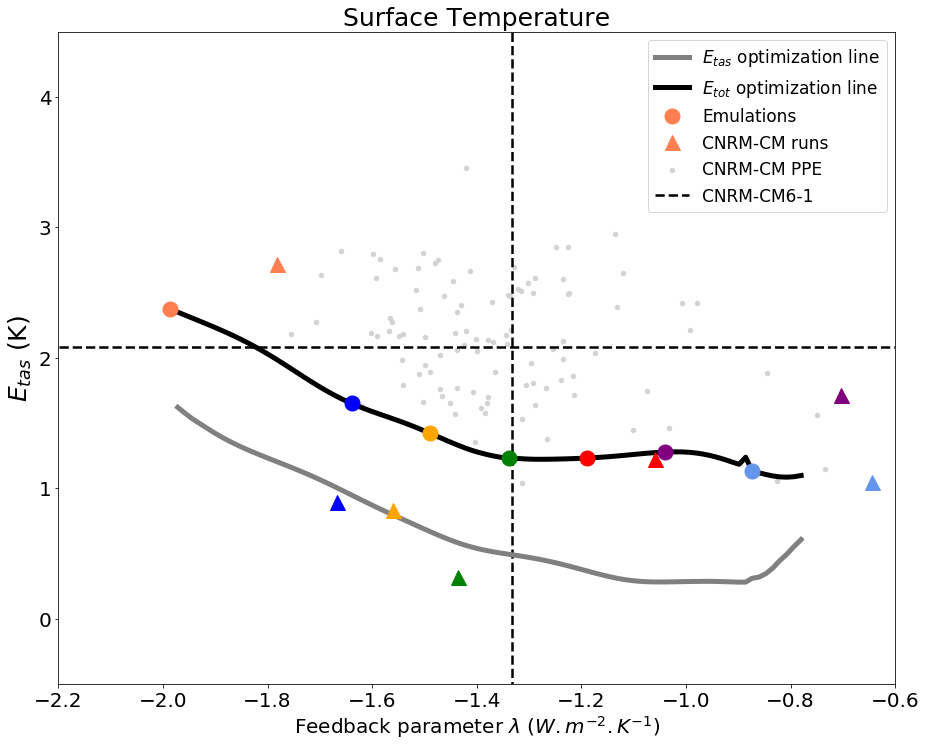

In [63]:
colors = ['coral','blue','orange','green','red','purple','cornflowerblue']
cpt=0

ax = plt.gca()

#new_df.plot(kind='scatter', x='Fdbck_pred', y='E_multilinreg_pred_best', color = 'darkgreen', alpha=0.3,
#         marker = '^', linewidth=6,  ax = ax)

#init_df.plot(kind='scatter', x='Fdbck', y='RMSE', color = 'darkgreen', alpha=1,
#         marker = '^', linewidth=6,  ax = ax)

#sol_df.plot(kind='line', x='Fdbck', y='sol_fun', color = 'darkgreen', alpha=0.3,
#         linewidth=3, ax = ax)

sol_df_2[1:].plot(kind='line', x='Fdbck', y='sol_fun', color = 'gray', alpha=1, linewidth=5, figsize=(15, 12), ax = ax)

df_optim_total_final.plot(kind='line', x='Fdbck', y='RMSE', color='black', alpha=1, linewidth=5, ax=ax)

#E_multilinreg_df.plot(kind='scatter', x='Fdbck', y='RMSE_total', 
#                           color='gray', alpha=0.2, figsize=(15, 12), marker='o', ax = ax)

PPE_df.plot(kind='scatter', x='Fdbck', y='E_PPE', color='lightgray', 
                     marker="o", ax = ax)

plt.hlines(E_p1,xmin = -10.0,xmax = 25.0,label='default simulation', colors='black', 
           linestyles='dashed', linewidth=2.5, zorder=1)
plt.vlines(p1_feedbacks,ymin = -10,ymax = 25,label='default simulation', colors='black', 
           linestyles='dashed', linewidth=2.5)

#plt.plot(Fdbck_MRI, E_MRI, color='orange', marker='s', markeredgewidth=0, markersize=15, zorder=20)
#plt.plot(Fdbck_CAN, E_CAN, color='navy', marker='s', markeredgewidth=2, markersize=15, zorder=30)
#plt.plot(Fdbck_MIROC, E_MIROC, color='darkred', marker='s', markeredgewidth=2, markersize=15, zorder=20)
#plt.plot(Fdbck_HadGEM3, E_HadGEM3, color='purple', marker='s', markeredgewidth=2, markersize=15, zorder=20)
#plt.plot(Fdbck_IPSL, E_IPSL, color='dodgerblue', marker='s', markeredgewidth=2, markersize=15, zorder=20)
#plt.plot(Fdbck_BCC, E_BCC, color='darkgreen', marker='s', markeredgewidth=2, markersize=15, zorder=20)


for i in colors :
    if cpt == 0 :
        plt.plot(df_select[1].iloc[cpt], E_emulator_selection[cpt], color=i, marker='o', linewidth=0, markersize=15, zorder=8)

        plt.plot(Fdbck_selection[cpt], E_df_selection[cpt], color=i, marker='^', linewidth=0, markersize=15, zorder=9)
        cpt+=1
    else :
        plt.plot(df_select[1].iloc[cpt], E_emulator_selection[cpt], color=i, marker='o', linewidth=0, markersize=15, label='_nolegend_')

        plt.plot(Fdbck_selection[cpt], E_df_selection[cpt], color=i, marker='^', linewidth=0, markersize=15, label='_nolegend_')
        cpt+=1

legend = [ '$E_{tas}$ optimization line','$E_{tot}$ optimization line', 'Emulations',
          'CNRM-CM runs', 'CNRM-CM PPE', 'CNRM-CM6-1']
plt.xlabel('Feedback parameter $\lambda$ ($W.m^{-2}.K^{-1}$)', fontsize=20)
plt.ylabel(ylabel, fontsize=25)
plt.legend(legend, fontsize=17) #bbox_to_anchor=(1.05, 1)

plt.title(TITLE, fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=20)
plt.ylim(-0.5,4.5)
plt.xlim(-2.2,-0.6)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/RMSE_"+variable+"_PPE_selection.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

### Save the data

In [44]:
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE4_selection/files/npy/E_selection_'+variable+'.npy', E_df_selection)

### [Back to the top](#top)